# TVB simulated resections and neural fragility analyses

We will simulate TVB for an epilepsy patient that underwent iEEG monitoring, and had subsequent resective surgery. They will have had a successful resection, indicating that the EZ was a subset of the resected region(s). 

The goal of this simulation is to show that neural fragility can guide resection and is linked to highlighting the epileptogenic zone and possibly propagation zones in the neural network.

**We will simulate resections that target either 100%, 50%, or 0% of the simulated EZ and compute neural fragility before and after.**

The initial sections will load the necessary metadata into RAM, and then the subsequent sections

- [Presection Simulation](#Preresection-Simulation)
- [Modeling the Successful Surgical Resection](#Modeling-the-Successful-Surgical-Resection)
- [Modeling the Partially Failed Surgical Resection](#Modeling-the-Partially-Failed-Surgical-Resection)
- [Modeling the Fully Failed Surgical Resection](#Modeling-the-Fully-Failed-Surgical-Resection)

Each of these simulation sections will model the brain as a coupled set of neural mass models. Each neural mass model will be comprised of an Epileptor and 2D oscillator to simulate interictal dynamics. The resection simulations will be either i) fully matched to the clinical resection, or ii) a series of possible failed situations. 

Finally, in [Comparing Resection Using Fragility](#Comparing-Resection-Using-Fragility), we will compare the simulations before/after resections with fragility heatmaps. This will then **demonstrate that fragility modulates with the success of a surgical resection in a virtual simulation.**

---

## Simulation setup

We have TVB connectivity data for a subject that underwent surgery and became seizure free. Thus the hypothesis is that the EZ was fully resected. The simulations will proceed as follows:

1. Load connectivity data and instantiate the simulation(s)
2. Run simulation and save intermediately generated simulated neural mass time series, sEEG time series and scalp EEG time series
3. Run fragility analysis

Notes on Simulation
===================
Note that the Epileptor is a generative model based on a stochastic differential equation, so therefore different parameters can vary in (nonlinear) ways that will produce different system behaviors. Namely, the `x0` parameter is said to impose the "degree of epileptogenicity" in the model. Regions with `x0 > -2.1` will spontaneously produce seizures. 

Limitations
-----------
Some limitations are that:
- the surgical resection depends on our placement of the simulated EZ
- there is a lack of interictal phenomena that can be modeled successfully by TVB
- TVB is unable to model the epileptic brain under anesthesia

---

References
----------
1. [Predicting the spatiotemporal diversity of seizure propagation and termination in human focal epilepsy](https://arxiv.org/pdf/1707.00772.pdf)
2. [On the Nature of Seizure Dynamics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4107736/pdf/awu133.pdf)

In [2]:
import numpy as np
import pandas as pd
import mne
from pprint import pprint
from natsort import natsorted

import os
import json
import os.path as op
from pathlib import Path
import collections

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
mne.utils.use_log_level('error')

import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, create_deriv_info, DerivativeArray
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

import sys
sys.path.append('../../../')
from sickkids.dmd.dmd import rescale_modes
from sickkids.posthoc.spectral import compute_significant_freqs, compute_bootstrap_lr
from sickkids.tvb.simulation import load_subject_connectivity, setup_simulation, resect_regions
from sickkids.tvb.utils import read_surf

_load_turbo()

# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

2021-01-25 23:35:50,886 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [3]:
from tvb.simulator.models.epileptor import Epileptor
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
from tvb.simulator.lab import cortex, local_connectivity

## Useful Functions

In [4]:
def compute_block_bootstrap_stats(pre_deriv, post_deriv, df_summ=None, desc=None, threshold=None):
    from hyppo.independence import MGC
    from hyppo.ksample import KSample
    import pingouin as pg

    # compute effect size difference with sub-sampling
    pre_blocks = pre_deriv.subsample_blocks(n_blocks=500)
    post_blocks = post_deriv.subsample_blocks(n_blocks=500)

    cohensd = []
    stats = []
    pvals = []

    for preb, postb in zip(pre_blocks, post_blocks):
        if threshold is not None:
            preb[preb < threshold] = np.nan
            postb[postb < threshold] = np.nan

        # drop any nans
        preb = preb[~np.isnan(preb)]
        postb = postb[~np.isnan(postb)]

        stat, pvalue = KSample("Dcorr").test(preb, postb)
        stats.append(stat)
        pvals.append(pvalue)

        es = pg.compute_effsize(preb, postb, 
                                paired=False, eftype='cohen')

        cohensd.append(es)
        
        if df_summ is not None:
            df_summ.append([desc, es, stat, pvalue])
    return cohensd, stats, pvals

In [5]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

## Set Parameters and Path

In [6]:
np.random.seed(12345)

In [7]:
# paths to data
root = Path('/Users/adam2392/Dropbox/resection_tvb/')
source_path = root / 'sourcedata'
experimental_condition = 'epilepsy'
subject = 'id008gc'
subject = 'id013pg'  # patient id with successful resection

subj_path = source_path / experimental_condition / subject
source_file = subj_path / 'tvb' / 'connectivity.zip'

In [8]:
output_path = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb')
output_path.mkdir(exist_ok=True, parents=True)

figures_path = output_path / 'metafigures'

print(subject)
print(output_path)

id013pg
/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb


In [9]:
# how to combine resting state 2D oscillator and Epileptor LFP values
p = 0.2

# derivative type
# column perturbations
derivtype = 'col'

## Create Output File Paths (Initial conditions, and output simulations)

In [10]:
# make sure subject doesn't have '_' character
subject = subject.replace('_', '')
print(subject)

# save data and the sEEG projections
rawsim_bids_path = BIDSPath(subject=subject, session='preresection', 
                     task='tvbsimezpz', 
                     acquisition='rs',
                     suffix='ieeg', run='01',
                     extension='.npz', check=False)
print(f'This is the filename that we will eventually save {rawsim_bids_path.basename}')

id013pg
This is the filename that we will eventually save sub-id013pg_ses-preresection_task-tvbsimezpz_acq-rs_run-01_ieeg.npz


In [11]:
# create a file path to save initial conditions to
initial_bids_path = BIDSPath(subject=subject, session='preresection', 
                     task='rs', 
                     suffix='epileptoric',
                     extension='.npy', check=False)

print(f'Initial conditions: {initial_bids_path}')

Initial conditions: sub-id013pg/ses-preresection/sub-id013pg_ses-preresection_task-rs_epileptoric.npy


In [12]:
# save data and the sEEG projections
succ_resect_bids_path = BIDSPath(subject=subject, 
                                 session='postresection', 
                     task='tvbsimezpz', suffix='ieeg',
                                 run='01',
                     extension='.npz', check=False)
print(succ_resect_bids_path.basename)

# save data and the sEEG projections
partial_resect_bids_path = BIDSPath(subject=subject, 
                                 session='postresection', 
                     task='tvbsimezpz', suffix='ieeg',
                                 run='02',
                     extension='.npz', check=False)

fail_resect_bids_path = BIDSPath(subject=subject, 
                                 session='postresection', 
                     task='tvbsimezpz', suffix='ieeg',
                                 run='03',
                     extension='.npz', check=False)

sub-id013pg_ses-postresection_task-tvbsimezpz_run-01_ieeg.npz


In [13]:
desc = 'perturbmatrix'

deriv_output_path = output_path / 'fragility'
deriv_output_path.mkdir(exist_ok=True)
print(deriv_output_path)

# save data and the sEEG projections
deriv_base_path = BIDSPath(subject=subject, session='preresection', 
                     task='tvbsimezpz', 
                     acquisition='rs',
                     suffix='ieeg', run='01',
                     extension='.npy', check=False)
deriv_base_path = _add_desc_to_bids_fname(deriv_base_path, desc)

# save data and the sEEG projections
deriv_succ_resect_path = BIDSPath(subject=subject, 
                                 session='postresection', 
                     task='tvbsimezpz', suffix='ieeg',
                                 run='01',
                     extension='.npy', check=False)
deriv_succ_resect_path = _add_desc_to_bids_fname(deriv_succ_resect_path, desc)
print(succ_resect_bids_path.basename)

# save data and the sEEG projections
deriv_partial_resect_path = BIDSPath(subject=subject, 
                                 session='postresection', 
                     task='tvbsimezpz', suffix='ieeg',
                                 run='02',
                     extension='.npy', check=False)
deriv_partial_resect_path = _add_desc_to_bids_fname(deriv_partial_resect_path, desc)

deriv_fail_resect_path = BIDSPath(subject=subject, 
                                 session='postresection', 
                     task='tvbsimezpz', suffix='ieeg',
                                 run='03',
                     extension='.npy', check=False)
deriv_fail_resect_path = _add_desc_to_bids_fname(deriv_fail_resect_path, desc)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/fragility
sub-id013pg_ses-postresection_task-tvbsimezpz_run-01_ieeg.npz


In [14]:
ch_xyz_fpath = subj_path / 'elec' / 'seeg.txt'
print(ch_xyz_fpath)

/Users/adam2392/Dropbox/resection_tvb/sourcedata/epilepsy/id013pg/elec/seeg.txt


In [15]:
gain_inv_fname = subj_path / 'elec' / 'gain_inv-square.txt'

print(gain_inv_fname)

/Users/adam2392/Dropbox/resection_tvb/sourcedata/epilepsy/id013pg/elec/gain_inv-square.txt


In [16]:
ezhypo_fpath = subj_path / 'tvb' / 'ez_hypothesis.txt'

print(ezhypo_fpath)

/Users/adam2392/Dropbox/resection_tvb/sourcedata/epilepsy/id013pg/tvb/ez_hypothesis.txt


In [17]:
initial_cond_fpath = output_path / initial_bids_path.basename

# Load Connectivity Data

We will load a preprocessed TVB connectivity dataset, which contains:

- areas.txt = The surface area in mm^3 of each region parcellation
- average_orientations.txt = The 3D orientation of each region parcellation
- centres.txt = The 3D centroid of each region
- cortical.txt = A binary flag of which region(s) are part of the cortical surface (others are part of the subcortical surface)
- tract_lengths.txt = The pairwise tract lengths matrix between all regions
- weights.txt = The pairwise weight matrix between all regions

In most of our datasets, these will be constructed from a `Desikan` atlas, which comprises of 84 distinct brain regions.

In [15]:
conn = load_subject_connectivity(
    source_file=str(source_file), condspeed=3.
)

# show the summary for this subject
print(conn)

WARNING  File 'hemispheres' not found in ZIP.
Connectivity (
  Number of connections ........................ 0
  Number of regions ............................ 0
  Undirected ................................... False
  areas [min, median, max] ..................... [340.84, 2223.93, 16020.4]
  areas dtype .................................. float64
  areas shape .................................. (84,)
  tract_lengths (connections) [min, median, max]  [12.19, 118.817, 197.187]
  tract_lengths [min, median, max] ............. [0, 116.056, 197.187]
  tract_lengths-non-zero [min, median, max] .... [12.19, 118.817, 197.187]
  weights [min, median, max] ................... [0, 0.000223561, 1]
  weights dtype ................................ float64
  weights shape ................................ (84, 84)
  weights-non-zero [min, median, max] .......... [3.54859e-06, 0.000266144, 1]
)


<ipython-input-16-f1c6f0e1e934>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')


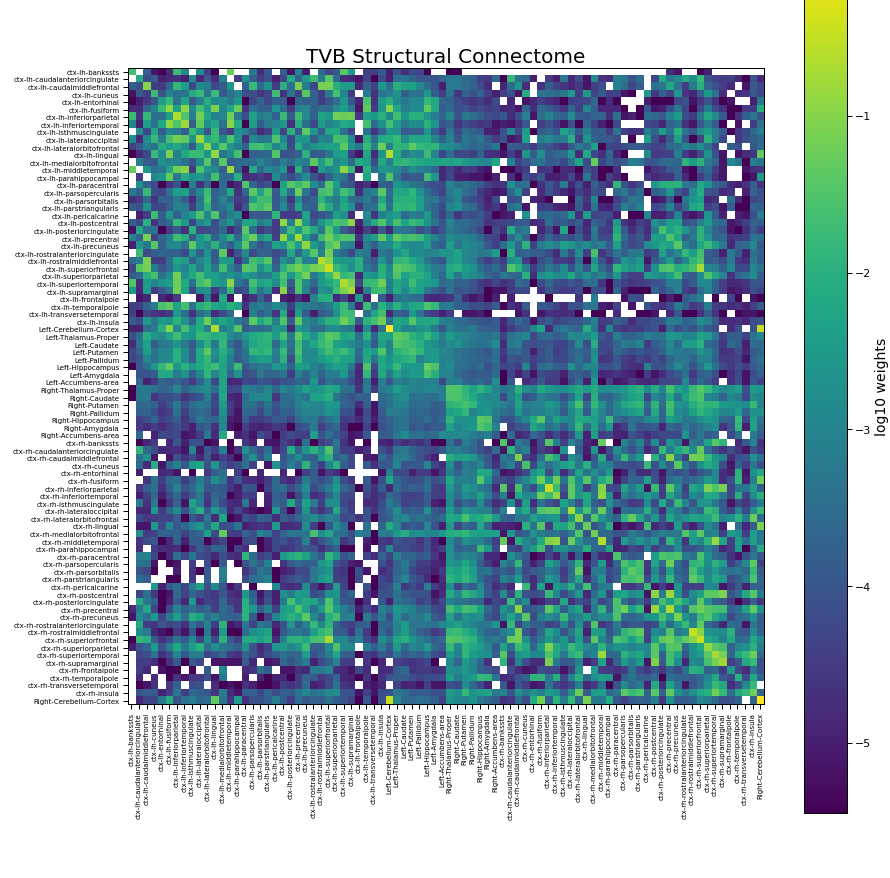

In [16]:
nregions = len(conn.region_labels)
# Visualization.
sns.set_context('paper', font_scale=1.25)
plt.figure(figsize=(13,13))
plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), conn.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), conn.region_labels, fontsize=7)
cb=plt.colorbar(
#     shrink=0.8
)
cb.set_label('log10 weights', fontsize=14)
plt.tight_layout()

figure_fname = output_path / 'metafigures' / f'{subject}-structuralconn.pdf'
figure_fname.parent.mkdir(exist_ok=True)
plt.savefig(figure_fname, bbox_inches='tight')

# Load in Channel Coordinates

Channel coordinates in 3D brain space should have been localized on a CT image and then coregistred and mapped to the brain space that the connectivity data was constructed from. This is generally derived from FreeSurfer.

Here is an example figure layout of sEEG electrode coordinates in 3 snapshots of Anterior/Posterior, Inferior/Superior, and Left/Right.
<div>
<img src="./seeg.png" width="70%"/>
</div>

In [17]:
# first load in the channel's xyz coordinates
seeg_pd = pd.read_csv(
    ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

ch_names = seeg_pd.index.values
ch_xyz = seeg_pd.to_numpy()
ch_pos = seeg_pd.T.to_dict(orient='list')

In [18]:
# got all the channels!
print(ch_names)
pprint(take(5, ch_pos.items()))

['TB1' 'TB2' 'TB3' 'TB4' 'TB5' 'TB6' 'TB7' 'TB8' 'TB9' 'A1' 'A2' 'A3' 'A4'
 'A5' 'A6' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'OT1'
 'OT2' 'OT3' 'OT4' 'OT5' 'OT6' 'OT7' 'OT8' 'OT9' 'C1' 'C2' 'C3' 'C4' 'C5'
 'C6' 'PI1' 'PI2' 'PI3' 'PI4' 'PI5' 'PI6' 'PI7' 'PI8' 'PI9' 'OP1' 'OP2'
 'OP3' 'OP4' 'OP5' 'OP6' 'OP7' 'OP8' 'OP9']
[('TB1', [37.37, 0.03, -34.55]),
 ('TB2', [40.87, 0.18, -34.49]),
 ('TB3', [44.36, 0.32, -34.43]),
 ('TB4', [47.86, 0.47, -34.37]),
 ('TB5', [51.35, 0.62, -34.31])]


# Initialize Epileptor Models At Brain Regions

In [19]:
print(conn.region_labels)

['ctx-lh-bankssts' 'ctx-lh-caudalanteriorcingulate'
 'ctx-lh-caudalmiddlefrontal' 'ctx-lh-cuneus' 'ctx-lh-entorhinal'
 'ctx-lh-fusiform' 'ctx-lh-inferiorparietal' 'ctx-lh-inferiortemporal'
 'ctx-lh-isthmuscingulate' 'ctx-lh-lateraloccipital'
 'ctx-lh-lateralorbitofrontal' 'ctx-lh-lingual'
 'ctx-lh-medialorbitofrontal' 'ctx-lh-middletemporal'
 'ctx-lh-parahippocampal' 'ctx-lh-paracentral' 'ctx-lh-parsopercularis'
 'ctx-lh-parsorbitalis' 'ctx-lh-parstriangularis' 'ctx-lh-pericalcarine'
 'ctx-lh-postcentral' 'ctx-lh-posteriorcingulate' 'ctx-lh-precentral'
 'ctx-lh-precuneus' 'ctx-lh-rostralanteriorcingulate'
 'ctx-lh-rostralmiddlefrontal' 'ctx-lh-superiorfrontal'
 'ctx-lh-superiorparietal' 'ctx-lh-superiortemporal'
 'ctx-lh-supramarginal' 'ctx-lh-frontalpole' 'ctx-lh-temporalpole'
 'ctx-lh-transversetemporal' 'ctx-lh-insula' 'Left-Cerebellum-Cortex'
 'Left-Thalamus-Proper' 'Left-Caudate' 'Left-Putamen' 'Left-Pallidum'
 'Left-Hippocampus' 'Left-Amygdala' 'Left-Accumbens-area'
 'Right-Thala

In [20]:
if subject == 'id013pg':
    ez_label = ['ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = ['Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
                'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 
elif subject == 'id008gc':
    ez_label = ['Right-Amygdala', 'Right-Hippocampus', 
#                                'ctx-rh-medialorbitofrontal',
               ]
    pz_label = [
#         'ctx-rh-superiortemporal', 
#                 'ctx-rh-middletemporal', 
                'ctx-rh-inferiortemporal', 
                'ctx-rh-temporalpole',
#                 'ctx-rh-lateralorbitofrontal'
               ]
else:
    ez_label = None
    pz_label = None

In [21]:
# read in the ez hypothesis regions
with open(ezhypo_fpath, 'r') as fin:
    ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
print(ez_hypo)
ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(f'\n\n EZ and PZ regions for {subject} are')
print(ez_regions, pz_regions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


 EZ and PZ regions for id013pg are
['ctx-rh-fusiform'] ['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-inferiortemporal']


## Get the resected channels

# Get Stable Initial Conditions

In [43]:
resting_state = True

if resting_state:
    epileptor_vars = ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'y_rs', 'x_rs', 'x2 - x1']
else:
    ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1']

In [170]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds,
    pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=epileptor_vars,
    r=0.00035 / 10, tt=0.75,
    resting_state=resting_state,
    x0ez=-2.10, x0pz=-2.15
)

[<tvb.simulator.monitors.TemporalAverage object at 0x14d33a5e0>, <tvb.simulator.monitors.iEEG object at 0x14d258910>]
   INFO  Projection configured gain shape (59, 84)


In [171]:
print(sim.model.a_rs)
print(sim.model.p)

[1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402 1.7402
 1.7402 1.7402 1.7402 1.7402]
[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]


In [172]:
(times, epilepts), (_, ieeg_mon_ts) = sim.run(simulation_length=1000)

In [186]:
print(epilepts.shape)
# get the discharges of each model
# for the epileptor: it is 'x2 - x1'
# for the 2D oscillator: it is 'x_rs'
epileptor_ts = epilepts[:, -1, :, :]
oscillator_ts = epilepts[:, 6, :, :]
region_ts = (epileptor_ts - oscillator_ts).squeeze()

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = seeg_epileptor_ts +seeg_rs_ts

print(seeg_epileptor_ts.shape, seeg_rs_ts.shape)
print(seeg_ts.shape, region_ts.shape)

(1000, 9, 84, 1)
(1000, 59) (1000, 59)
(1000, 59) (1000, 84)


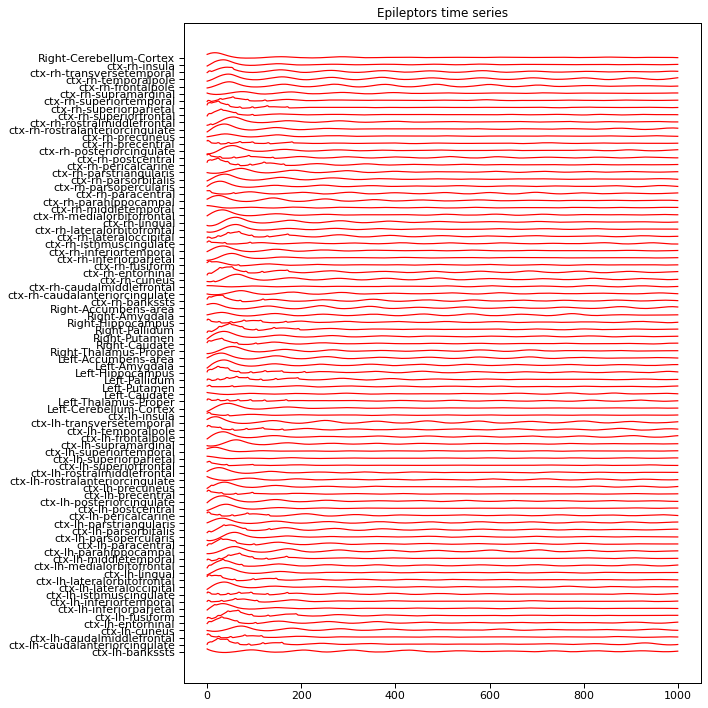

In [176]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], region_ts / (np.max(region_ts.max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

['TB1' 'TB2' 'TB3' 'TB4' 'TB5' 'TB6' 'TB7' 'TB8' 'TB9' 'A1' 'A2' 'A3' 'A4'
 'A5' 'A6' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'OT1'
 'OT2' 'OT3' 'OT4' 'OT5' 'OT6' 'OT7' 'OT8' 'OT9' 'C1' 'C2' 'C3' 'C4' 'C5'
 'C6' 'PI1' 'PI2' 'PI3' 'PI4' 'PI5' 'PI6' 'PI7' 'PI8' 'PI9' 'OP1' 'OP2'
 'OP3' 'OP4' 'OP5' 'OP6' 'OP7' 'OP8' 'OP9']


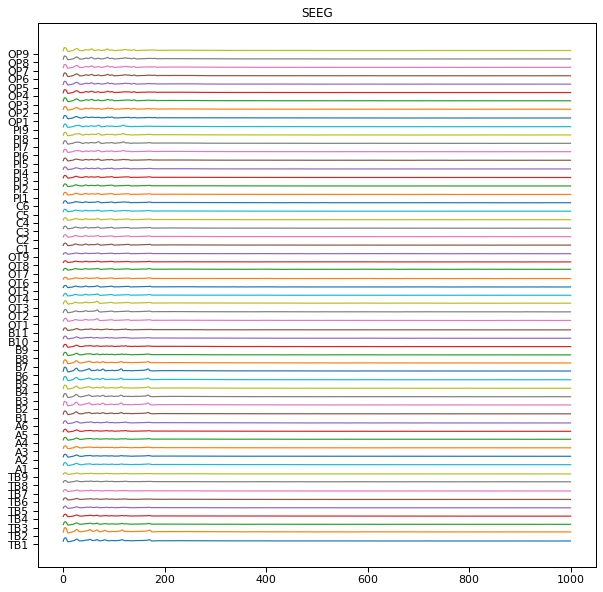

In [188]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg_epileptor_ts / (np.max(seeg_epileptor_ts.max(axis=0))) + np.r_[:len(ch_names)])
plt.yticks(np.r_[:len(ch_names)], ch_names[:len(ch_names)])
plt.title("SEEG")

print(ch_names)

In [189]:
# note that there are now 7 state variables
# the first 6 are part of the Epileptor fast/slow/veryslow subsystems 
# the last 1 is the actual time series that is projected to the sEEG electrode locations
print(epilepts.shape)

(1000, 9, 84, 1)


In [190]:
# initial_conditions = epilepts[2100, :-1, ...][np.newaxis, ...]
print(initial_conditions.shape)

(1, 8, 84, 1)


In [203]:
# we store the initial conditions as a 6x1 array
initial_conditions = epilepts[-1, :-1, :, :][np.newaxis, ...]


print(initial_bids_path.basename)
print(initial_conditions.shape)

sub-id013pg_ses-preresection_task-rs_epileptor.npy
(1, 8, 84, 1)


In [204]:
# save initial conditions into a numpy array
np.save(initial_cond_fpath, initial_conditions)
print(f'Saved initial conditions to: {initial_cond_fpath}')

Saved initial conditions to: /Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/sub-id013pg_ses-preresection_task-rs_epileptor.npy


In [205]:

# re-run simulation and check that initial conditions worked
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=epileptor_vars,
    r=0.00035 / 10, tt=0.75, initial_conditions=initial_conditions,
    resting_state=resting_state,     x0ez=-2.05, x0pz=-2.10
#     resected_chs=resected_chs
)

(times, epilepts), (_, seegts) = sim.run(simulation_length=15000)

[<tvb.simulator.monitors.TemporalAverage object at 0x14f7af3d0>, <tvb.simulator.monitors.iEEG object at 0x14f7af4c0>]
   INFO  Projection configured gain shape (59, 84)


KeyboardInterrupt: 

In [154]:
# region_ts = 
print(epilepts.shape)
print(sim.model.variables_of_interest)

# get the discharges of each model
# for the epileptor: it is 'x2 - x1'
# for the 2D oscillator: it is 'x_rs'
epileptor_ts = epilepts[:, -1, :, :]
oscillator_ts = epilepts[:, 6, :, :]
region_ts = (epileptor_ts - oscillator_ts).squeeze()

print(region_ts.shape)

(15000, 9, 84, 1)
['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x_rs', 'y_rs', 'x2 - x1']
(15000, 84)


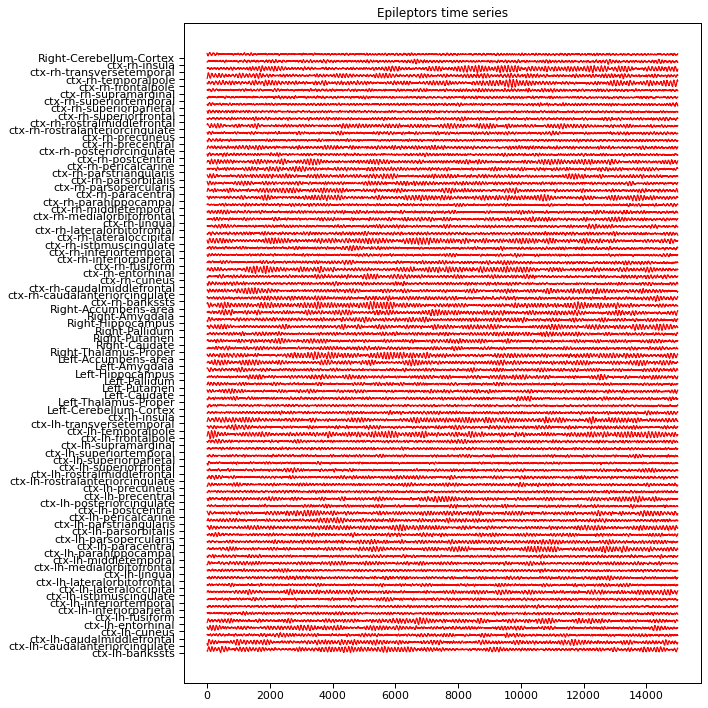

In [153]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], region_ts / (np.max(region_ts[:, :].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

# Setup Final Simulation Object

In [22]:
# only use this if you are loading in initial conditions
# for simulation to start from
initial_conditions = np.load(initial_cond_fpath)
print(initial_conditions.shape)

(1, 8, 84, 1)


In [207]:
print(ezhypo_inds, pzhypo_inds)

(array([54]),) (array([46, 47, 56]),)


In [211]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=epileptor_vars,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
    x0ez=-2.08, x0pz=-2.10, resting_state=resting_state
#     pzind=pzhypo_inds,
)

[<tvb.simulator.monitors.TemporalAverage object at 0x14fabcb80>, <tvb.simulator.monitors.iEEG object at 0x14fabca90>]
   INFO  Projection configured gain shape (59, 84)


In [212]:
print(sim)

Simulator (
  Type ................................ Simulator
  conduction_speed .................... 3.0
  connectivity ........................ Connectivity gid: ce0d8ecb-a406-43f6-921c-9a6a9c5f2724
  coupling ............................ Difference gid: c910a793-f4e8-4ad4-83b3-bb1eb2cdccfc
  gid ................................. UUID('3f0062af-4ed2-45c1-ae73-6a948a567546')
  initial_conditions [min, median, max]  [-18.1266, -0.19077, 3.93749]
  initial_conditions dtype ............ float64
  initial_conditions shape ............ (1, 8, 84, 1)
  integrator .......................... HeunStochastic gid: d175979a-cba0-43bf-863e-a3b56c0cb460
  model ............................... EpileptorRestingState gid: d35cf882-7ef9-4087-a6ed-bab20abe17fd
  monitors ............................ [<tvb.simulator.monitors.TemporalAverage object at 0x14fabcb80>, <tvb.simulator.monitors.iEEG object at 0x14fabca90>]
  simulation_length ................... 1000.0
  stimulus ............................ No

# Preresection Simulation

In [213]:
sim_length = 30000
(times, epilepts), (_, ieeg_mon_ts) = sim.run(
        simulation_length=sim_length)

In [214]:
# get the actual data arrays

# get the discharges of each model
# for the epileptor: it is 'x2 - x1'
# for the 2D oscillator: it is 'x_rs'
epileptor_ts = epilepts[:, -1, :, :]
oscillator_ts = epilepts[:, 6, :, :]
region_ts = (epileptor_ts - oscillator_ts).squeeze()

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = seeg_epileptor_ts +seeg_rs_ts

print(seeg_epileptor_ts.shape, seeg_rs_ts.shape)
print(seeg_ts.shape, region_ts.shape)

(30000, 59) (30000, 59)
(30000, 59) (30000, 84)


In [224]:
seeg = seeg_ts.copy()
tavg = region_ts.copy()

In [216]:
# Normalize the time series to have nice plots
# tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
# seeg /= (np.max(seeg,0) - np.min(seeg, 0))
# seeg -= np.mean(seeg, 0)

In [217]:
print(len(conn.region_labels))
print(epilepts.shape)
print(epilepts[:, 0, :, 0].max(axis=0).shape)

84
(30000, 9, 84, 1)
(84,)


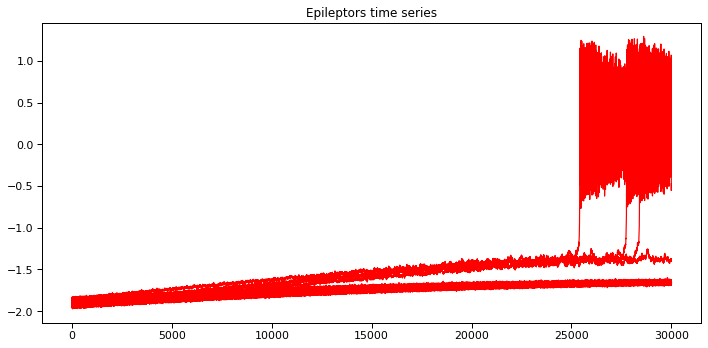

In [218]:
#Plot raw time series
plt.figure(figsize=(10,5))
plt.plot(times[:], epilepts[:, 0, :, 0]
#          + np.r_[:len(conn.region_labels)]
         , 'r')
plt.title("Ultra-slow scale (z-variable) Epileptors time series")
# plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()



(30000, 84)


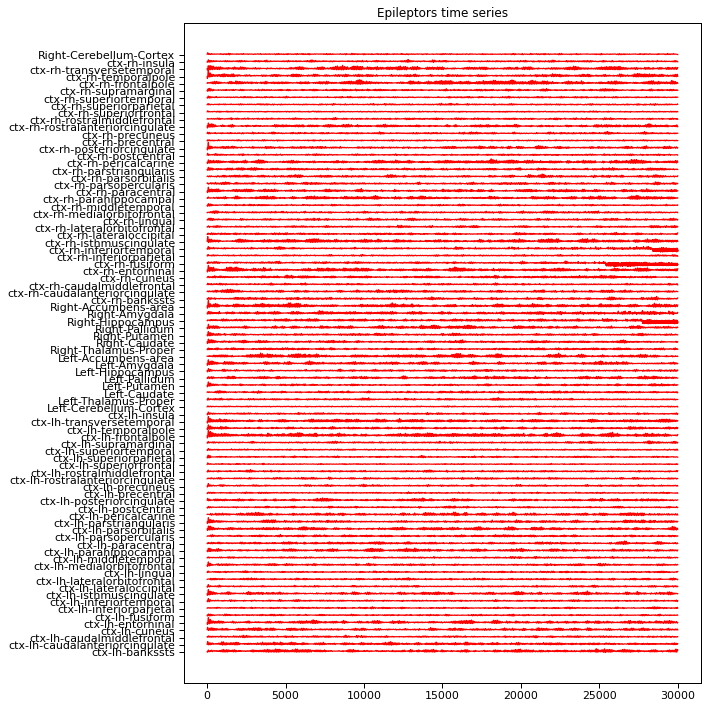

In [223]:
print(region_ts.shape)
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], region_ts / (np.max(region_ts.max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

['TB1' 'TB2' 'TB3' 'TB4' 'TB5' 'TB6' 'TB7' 'TB8' 'TB9' 'A1' 'A2' 'A3' 'A4'
 'A5' 'A6' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'OT1'
 'OT2' 'OT3' 'OT4' 'OT5' 'OT6' 'OT7' 'OT8' 'OT9' 'C1' 'C2' 'C3' 'C4' 'C5'
 'C6' 'PI1' 'PI2' 'PI3' 'PI4' 'PI5' 'PI6' 'PI7' 'PI8' 'PI9' 'OP1' 'OP2'
 'OP3' 'OP4' 'OP5' 'OP6' 'OP7' 'OP8' 'OP9']


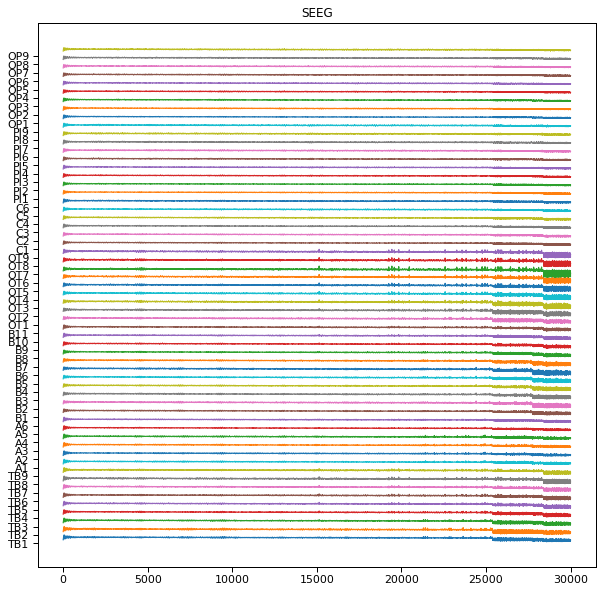

In [226]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg / np.max(seeg, axis=0) + np.r_[:len(ch_names)])
plt.yticks(np.r_[:len(ch_names)], ch_names[:len(ch_names)])
plt.title("SEEG")

print(ch_names)

In [222]:
# save simulated data time series
np.savez_compressed(output_path / rawsim_bids_path.basename, 
                   epilepts=epilepts, 
                ieeg_mon_ts=ieeg_mon_ts, 
                    times=times,
                   ch_names=ch_names, region_names=conn.region_labels)

## Fragility Analysis of the Original Simulation

In [61]:
# load the pre-resection data
data_dict = np.load(output_path / rawsim_bids_path.basename, allow_pickle=True)
print(data_dict.keys())

# load in the resected data
ieeg_mon_ts = data_dict['ieeg_mon_ts']
ch_names = data_dict['ch_names']

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = p * seeg_epileptor_ts + (1-p)* seeg_rs_ts

print(seeg_ts.shape, ch_names.shape)

KeysView(<numpy.lib.npyio.NpzFile object at 0x151c308e0>)
(30000, 59) (59,)


In [62]:
seegdata = seeg_ts.squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=list(ch_names), 
                   ch_types='seeg')
raw = RawArray(seegdata, info=info)

# drop channels if this is a resected simulation
# resected_raw.drop_channels(resected_ch_names)

# pick types and load data to RAM
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)
raw = raw.notch_filter(freqs, method='fir')

(59, 30000)
<RawArray | 59 x 30000 (30.0 s), ~13.6 MB, data loaded>


In [63]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (59, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:12<00:00, 19.81eeg window/s]


(59,) (59, 59) (59, 59)


/Users/adam2392/Documents/eztrack/eztrack/fragility/fragility.py:745: ComplexWarning: Casting complex values to real discards the imaginary part
  A_mats[..., i] = adjmat
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

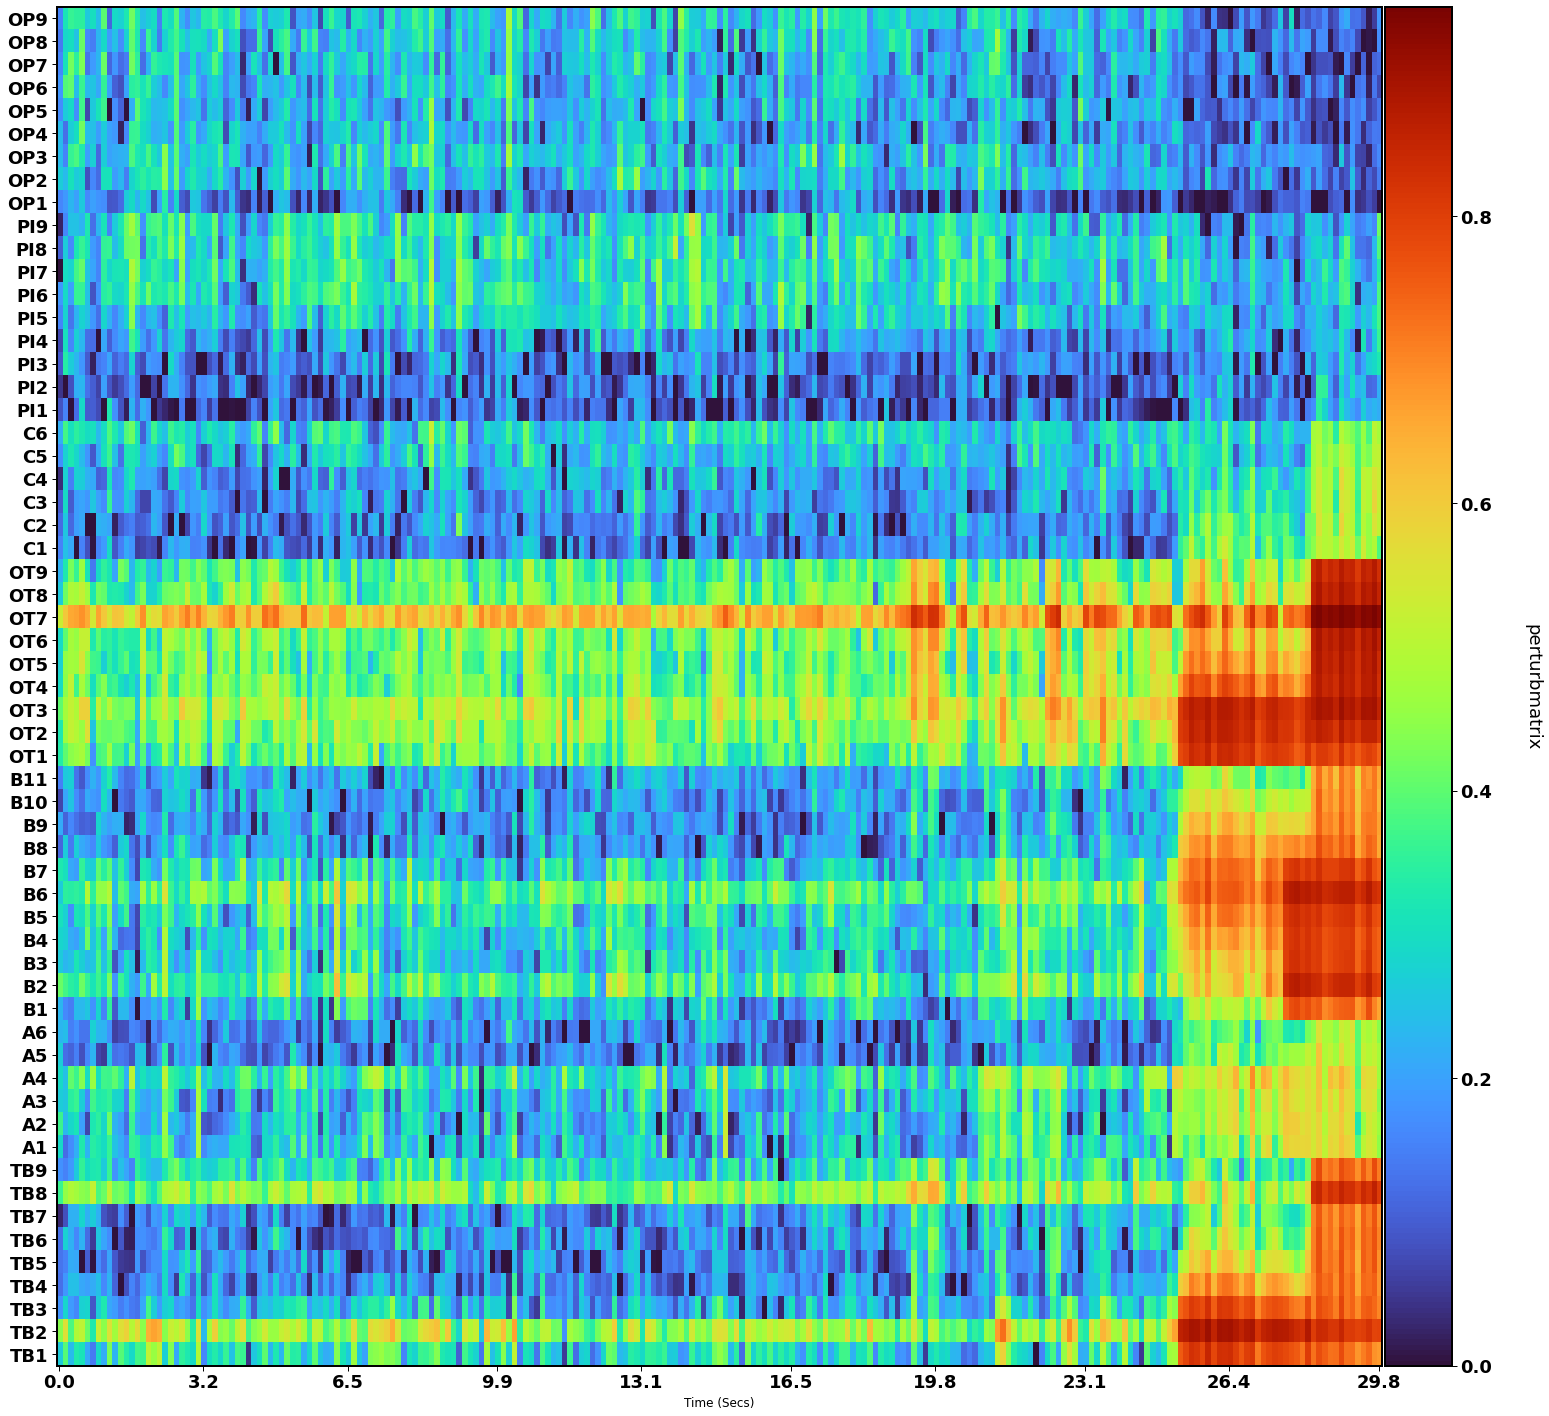

In [30]:
# pert_deriv.normalize()
# pert_deriv.plot_heatmap()

In [65]:
pert_deriv.save(deriv_output_path / deriv_base_path, overwrite=True)

PosixPath('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/fragility/sub-id013pg/ses-preresection/ieeg/sub-id013pg_ses-preresection_task-tvbsimezpz_acq-rs_run-01_desc-perturbmatrix_ieeg.npy')

# Modeling the Successful Surgical Resection

## Set Resective Region

In [193]:
if subject == 'id013pg':
    ez_label = ['ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = ['Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
                'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 
elif subject == 'id008gc':
    ez_label = ['Right-Amygdala', 'Right-Hippocampus', 
#                                'ctx-rh-medialorbitofrontal'
               ]
    pz_label = [
#         'ctx-rh-superiortemporal', 
#                 'ctx-rh-middletemporal', 
                'ctx-rh-inferiortemporal', 
                'ctx-rh-temporalpole',
#                 'ctx-rh-lateralorbitofrontal'
               ]
else:
    ez_label = None
    pz_label = None

In [194]:
# read in the ez hypothesis regions
with open(ezhypo_fpath, 'r') as fin:
    ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
print(ez_hypo)
ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(ez_regions, pz_regions)
print(ezhypo_inds)
print(ez_regions)
print(pzhypo_inds)
print(pz_regions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
['ctx-rh-fusiform'] ['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-inferiortemporal']
(array([54]),)
['ctx-rh-fusiform']
(array([46, 47, 56]),)
['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-inferiortemporal']


## Resect region on Structural Connectivity and Remove Channels

In [91]:
conn = resect_regions(conn, ezhypo_inds)
conn = resect_regions(conn, pzhypo_inds)
print(conn.summary_info())

{'Number of regions': 84, 'Number of connections': 6090, 'Undirected': True, 'areas shape': '(84,)', 'areas dtype': 'float64', 'areas [min, median, max]': '[340.84, 2223.93, 16020.4]', 'weights shape': '(84, 84)', 'weights dtype': 'float64', 'weights [min, median, max]': '[0, 0.000159687, 1]', 'weights-non-zero [min, median, max]': '[3.54859e-06, 0.00027679, 1]', 'tract_lengths [min, median, max]': '[0, 116.056, 197.187]', 'tract_lengths-non-zero [min, median, max]': '[12.19, 118.817, 197.187]', 'tract_lengths (connections) [min, median, max]': '[12.19, 119.377, 197.187]'}


In [114]:
# load the location of each electrodes
electrodes_path = rawsim_bids_path.copy().update(
    root=root, task=None, run=None, suffix='electrodes', 
    session='extraoperative',
    acquisition='seeg', space='mri', extension='.tsv')
print(electrodes_path)

elec_df = pd.read_csv(electrodes_path, delimiter='\t')
display(elec_df.head())

elec_names = elec_df.name.tolist()
elec_regions = elec_df['desikan-killiany'].tolist()

print(elec_names)
# resected channels
resected_chs = [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in ez_label]
pz_resected_chs =  [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in pz_label]
resected_chs.extend(pz_resected_chs)
print('Resected these channels: ', resected_chs)

/Users/adam2392/Dropbox/resection_tvb/sub-id013pg/ses-extraoperative/ieeg/sub-id013pg_ses-extraoperative_acq-seeg_space-mri_electrodes.tsv


name      x     y      z  size desikan-killiany
0   A1    NaN   NaN    NaN   NaN   Right-Amygdala
1   A2    NaN   NaN    NaN   NaN   Right-Amygdala
2   A3  40.56  0.72 -22.77   NaN   Right-Amygdala
3   A4  44.05  0.77 -22.95   NaN   Right-Amygdala
4   A5  47.55  0.82 -23.12   NaN   Right-Amygdala

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9', 'OT10', 'OP1', 'OP2', 'OP3', 'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9', 'OP10', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'PI10', 'ECG']
Resected these channels:  ['TB1', 'TB2', 'TB3', 'OT1', 'OT2', 'OT3', 'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'TB4', 'TB5', 'TB6', 'TB8', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9']


In [115]:
# ez_label = ['ctx-rh-medialorbitofrontal']
# pz_label = ['ctx-rh-lateralorbitofrontal']
# # get the hypothesized EZ and PZ
# ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
# ez_regions = conn.region_labels[ezhypo_inds]

# pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
# pz_regions = conn.region_labels[pzhypo_inds]


In [116]:
# and re-save it as a temporary file
seeg_pd = pd.read_csv(ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

# load in the gain file and remove the indices
ch_names = seeg_pd.index
seeg_pd.drop(resected_chs, inplace=True)

# resave the dataframe
# new_seeg_fname = os.path.join(temp_path, os.path.basename(seeg_fname))
# seeg_pd.to_csv('./test.txt', sep=' ', columns=None, header=False)

In [117]:
nrz_ch_names = [ch for ch in ch_names if ch not in resected_chs]

print('Channels not resected...')
print(nrz_ch_names)

Channels not resected...
['TB7', 'TB9', 'A6', 'B10', 'B11', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'OP1', 'OP2', 'OP3', 'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9']


## Setup Resected Brain Simulation

In [118]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
#     ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
    resected_chs=resected_chs,
    variables_of_interest=epileptor_vars,
    x0ez=-2.08, x0pz=-2.10, resting_state=resting_state
)

[<tvb.simulator.monitors.TemporalAverage object at 0x1495fbd30>, <tvb.simulator.monitors.iEEG object at 0x1494ccca0>]
   INFO  Projection configured gain shape (29, 84)


In [119]:
sim_length = 30000
(times, epilepts), (_, ieeg_mon_ts) = sim.run(
        simulation_length=sim_length)

In [120]:
# get the actual data arrays

# get the discharges of each model
# for the epileptor: it is 'x2 - x1'
# for the 2D oscillator: it is 'x_rs'
epileptor_ts = epilepts[:, -1, :, :]
oscillator_ts = epilepts[:, 6, :, :]
region_ts = (epileptor_ts - oscillator_ts).squeeze()

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = seeg_epileptor_ts +seeg_rs_ts

print(seeg_epileptor_ts.shape, seeg_rs_ts.shape)
print(seeg_ts.shape, region_ts.shape)

(30000, 29) (30000, 29)
(30000, 29) (30000, 84)


## Visualize and save output of the simulation

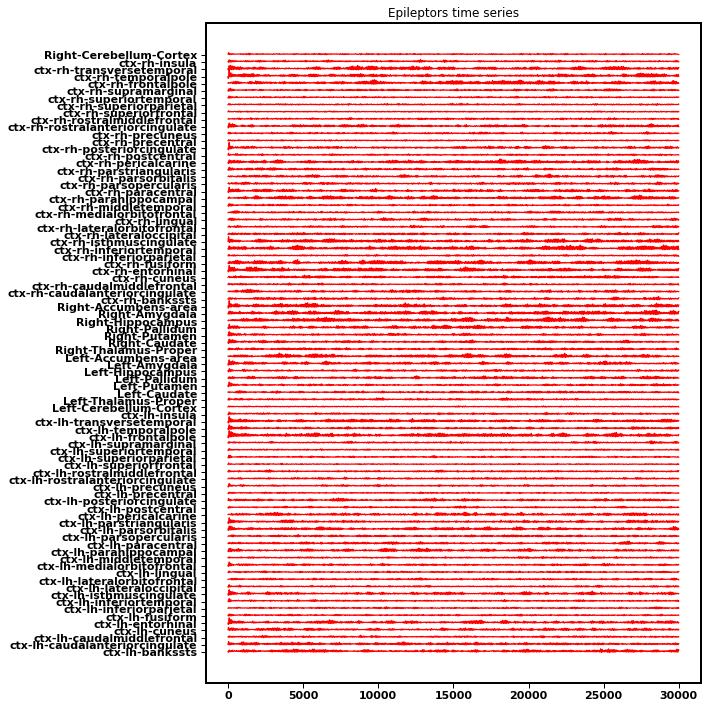

In [121]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], region_ts / (np.max(region_ts.max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

Index(['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'A1',
       'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B9', 'B10', 'B11', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6',
       'OT7', 'OT8', 'OT9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2',
       'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'OP1', 'OP2', 'OP3',
       'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9'],
      dtype='object')


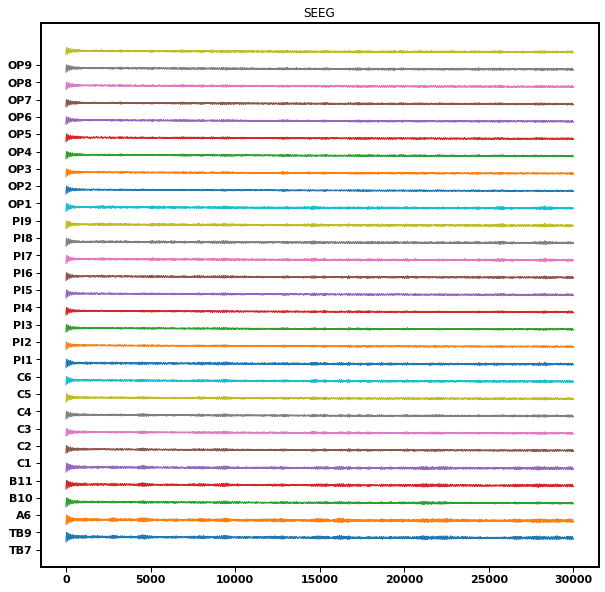

In [122]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg_ts / np.max(seeg_ts, axis=0)  + np.r_[:len(nrz_ch_names)])
plt.yticks(np.r_[:len(nrz_ch_names)], nrz_ch_names[:len(nrz_ch_names)])
plt.title("SEEG")

print(ch_names)

In [123]:
resected_ch_names = [ch for ch in ch_names if ch not in resected_chs]
print(len(resected_ch_names))

print(ieeg_mon_ts.shape, epilepts.shape)

29
(30000, 2, 29, 1) (30000, 9, 84, 1)


In [124]:
np.savez_compressed(output_path / succ_resect_bids_path.basename, 
                   epilepts=epilepts, ieeg_mon_ts=ieeg_mon_ts,
                    times=times,
                   ch_names=resected_ch_names, region_names=conn.region_labels)

## Fragility Analysis

In [36]:
# load the pre-resection data
data_dict = np.load(output_path / succ_resect_bids_path.basename, allow_pickle=True)
print(data_dict.keys())

# load in the resected data
ieeg_mon_ts = data_dict['ieeg_mon_ts']
ch_names = data_dict['ch_names']

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = p * seeg_epileptor_ts + (1-p)* seeg_rs_ts

print(seeg_ts.shape, ch_names.shape)

KeysView(<numpy.lib.npyio.NpzFile object at 0x153884f70>)
(30000, 29) (29,)


In [37]:
seegdata = seeg_ts.squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=list(ch_names), 
                   ch_types='seeg')
raw = RawArray(seegdata, info=info)

# drop channels if this is a resected simulation
# resected_raw.drop_channels(resected_ch_names)

# pick types and load data to RAM
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)
raw = raw.notch_filter(freqs, method='fir')

(29, 30000)
<RawArray | 29 x 30000 (30.0 s), ~6.7 MB, data loaded>


In [38]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (29, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:08<00:00, 29.32eeg window/s]


(29,) (29, 29) (29, 29)


/Users/adam2392/Documents/eztrack/eztrack/fragility/fragility.py:745: ComplexWarning: Casting complex values to real discards the imaginary part
  A_mats[..., i] = adjmat
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

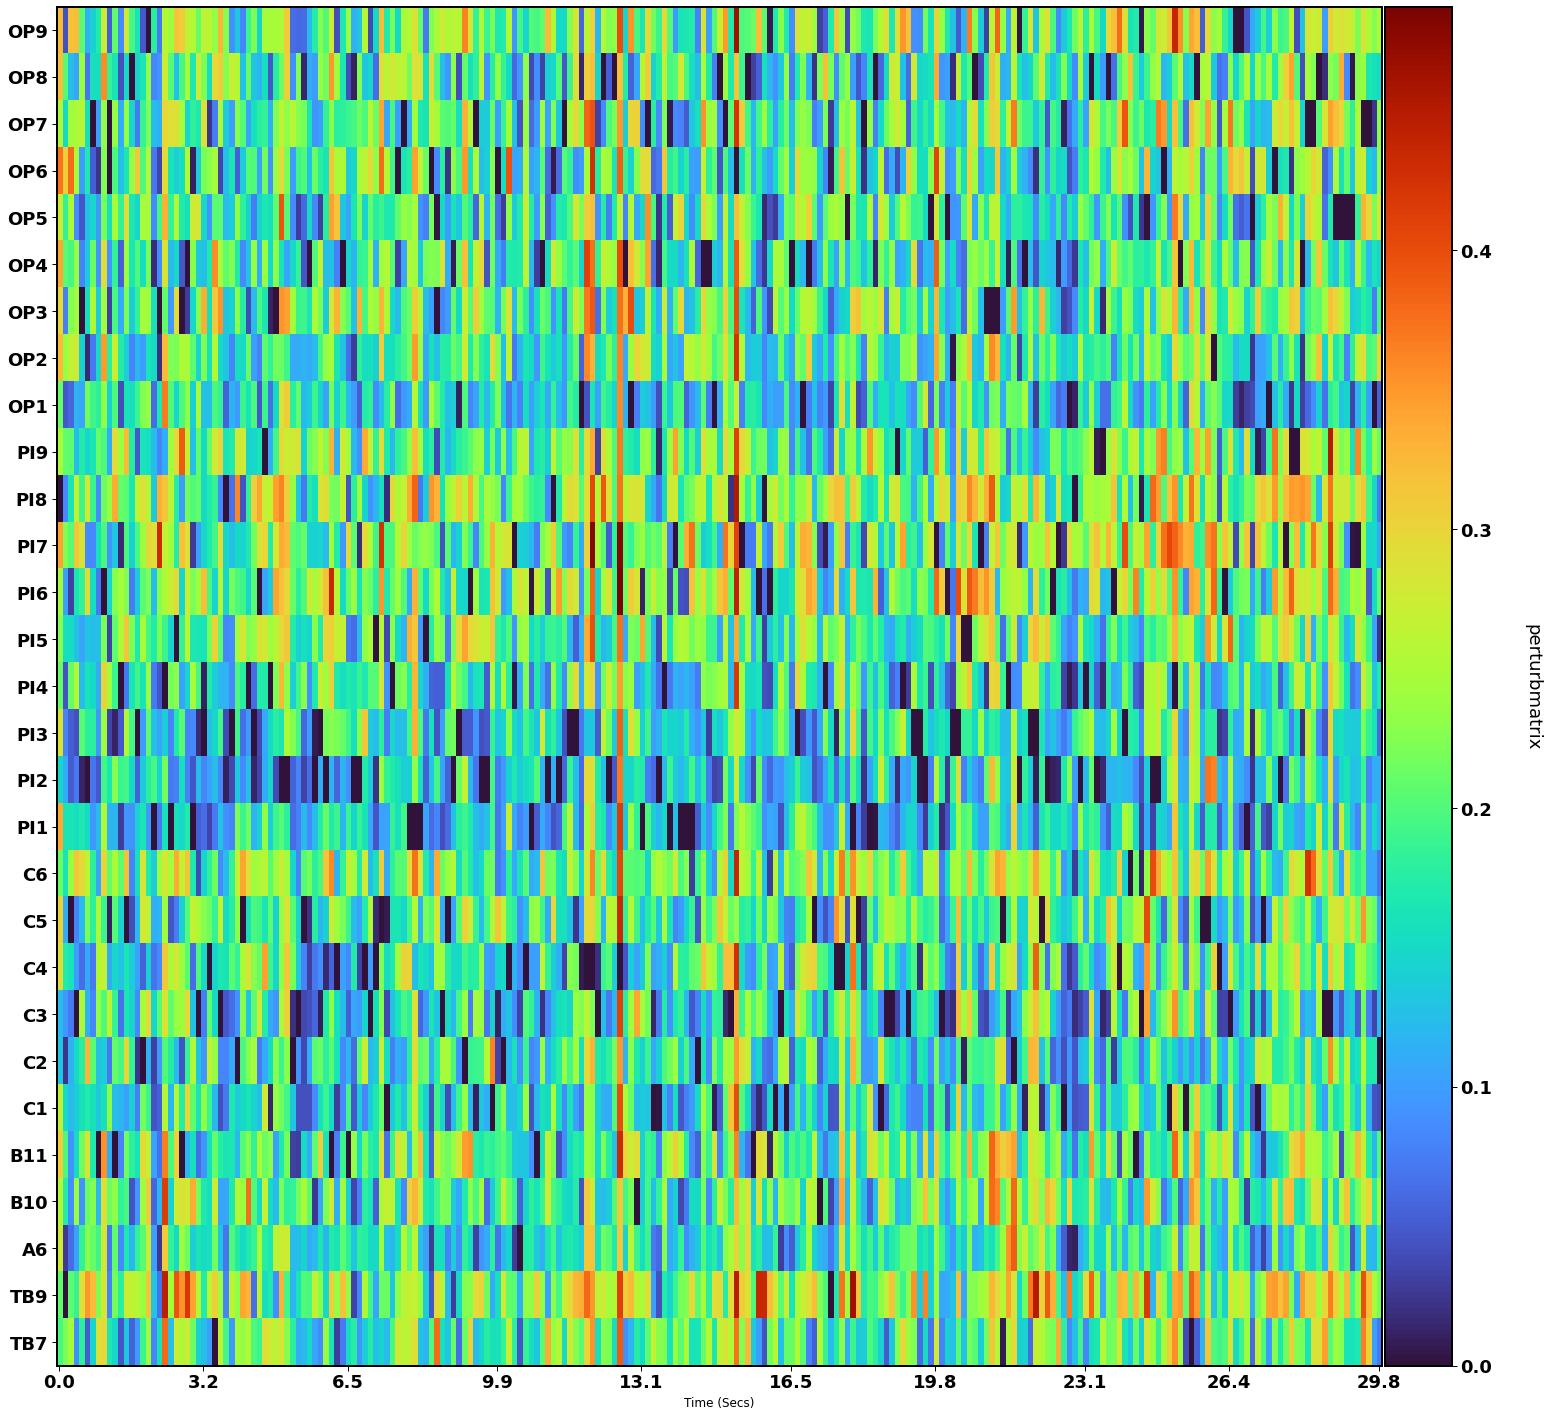

In [130]:
pert_deriv.normalize()

pert_deriv.plot_heatmap()

In [39]:
pert_deriv.save(deriv_output_path / deriv_succ_resect_path)

PosixPath('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/fragility/sub-id013pg/ses-postresection/ieeg/sub-id013pg_ses-postresection_task-tvbsimezpz_run-01_desc-perturbmatrix_ieeg.npy')

# Modeling the Partially Failed Surgical Resection

## Set Resective Region

In [40]:
if subject == 'id013pg':
    ez_label = [
#         'ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = [
        'Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
                'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 

In [41]:
# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(ez_regions, pz_regions)
print(ezhypo_inds)
print(ez_regions)
print(pzhypo_inds)
print(pz_regions)

[] ['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-inferiortemporal']
(array([], dtype=int64),)
[]
(array([46, 47, 56]),)
['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-inferiortemporal']


## Resect region on Structural Connectivity and Remove Channels

In [134]:
conn = resect_regions(conn, ezhypo_inds)
conn = resect_regions(conn, pzhypo_inds)
print(conn.summary_info())

{'Number of regions': 0, 'Number of connections': 0, 'Undirected': False, 'areas shape': '(84,)', 'areas dtype': 'float64', 'areas [min, median, max]': '[340.84, 2223.93, 16020.4]', 'weights shape': '(84, 84)', 'weights dtype': 'float64', 'weights [min, median, max]': '[0, 0.000173881, 1]', 'weights-non-zero [min, median, max]': '[3.54859e-06, 0.00027679, 1]', 'tract_lengths [min, median, max]': '[0, 116.056, 197.187]', 'tract_lengths-non-zero [min, median, max]': '[12.19, 118.817, 197.187]', 'tract_lengths (connections) [min, median, max]': '[12.19, 119.286, 197.187]'}


In [135]:
# load the location of each electrodes
electrodes_path = rawsim_bids_path.copy().update(
    root=root, task=None, run=None, suffix='electrodes', 
    session='extraoperative',
    acquisition='seeg', space='mri', extension='.tsv')
print(electrodes_path)

elec_df = pd.read_csv(electrodes_path, delimiter='\t')
display(elec_df.head())

elec_names = elec_df.name.tolist()
elec_regions = elec_df['desikan-killiany'].tolist()

print(elec_names)
# resected channels
resected_chs = [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in ez_label]
pz_resected_chs =  [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in pz_label]
resected_chs.extend(pz_resected_chs)
print('Resected these channels: ', resected_chs)

/Users/adam2392/Dropbox/resection_tvb/sub-id013pg/ses-extraoperative/ieeg/sub-id013pg_ses-extraoperative_acq-seeg_space-mri_electrodes.tsv


name      x     y      z  size desikan-killiany
0   A1    NaN   NaN    NaN   NaN   Right-Amygdala
1   A2    NaN   NaN    NaN   NaN   Right-Amygdala
2   A3  40.56  0.72 -22.77   NaN   Right-Amygdala
3   A4  44.05  0.77 -22.95   NaN   Right-Amygdala
4   A5  47.55  0.82 -23.12   NaN   Right-Amygdala

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9', 'OT10', 'OP1', 'OP2', 'OP3', 'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9', 'OP10', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'PI10', 'ECG']
Resected these channels:  ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'TB4', 'TB5', 'TB6', 'TB8', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9']


In [136]:
# ez_label = ['ctx-rh-medialorbitofrontal']
# pz_label = ['ctx-rh-lateralorbitofrontal']
# # get the hypothesized EZ and PZ
# ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
# ez_regions = conn.region_labels[ezhypo_inds]

# pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
# pz_regions = conn.region_labels[pzhypo_inds]


In [137]:
# and re-save it as a temporary file
seeg_pd = pd.read_csv(ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

# load in the gain file and remove the indices
ch_names = seeg_pd.index
seeg_pd.drop(resected_chs, inplace=True)

# resave the dataframe
# new_seeg_fname = os.path.join(temp_path, os.path.basename(seeg_fname))
# seeg_pd.to_csv('./test.txt', sep=' ', columns=None, header=False)

In [138]:
nrz_ch_names = [ch for ch in ch_names if ch not in resected_chs]

print('Channels not resected...')
print(nrz_ch_names)

Channels not resected...
['TB1', 'TB2', 'TB3', 'TB7', 'TB9', 'A6', 'B10', 'B11', 'OT1', 'OT2', 'OT3', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'OP1', 'OP2', 'OP3', 'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9']


## Setup Resected Brain Simulation

In [139]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
#     ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
    resected_chs=resected_chs,
    variables_of_interest=epileptor_vars,
    x0ez=-2.08, x0pz=-2.10, resting_state=resting_state
)

[<tvb.simulator.monitors.TemporalAverage object at 0x14a16ad90>, <tvb.simulator.monitors.iEEG object at 0x149bc0100>]
   INFO  Projection configured gain shape (35, 84)


In [140]:
sim_length = 30000
(times, epilepts), (_, ieeg_mon_ts) = sim.run(
        simulation_length=sim_length)

In [141]:
# get the actual data arrays

# get the discharges of each model
# for the epileptor: it is 'x2 - x1'
# for the 2D oscillator: it is 'x_rs'
epileptor_ts = epilepts[:, -1, :, :]
oscillator_ts = epilepts[:, 6, :, :]
region_ts = (epileptor_ts - oscillator_ts).squeeze()

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = seeg_epileptor_ts +seeg_rs_ts

print(seeg_epileptor_ts.shape, seeg_rs_ts.shape)
print(seeg_ts.shape, region_ts.shape)

(30000, 35) (30000, 35)
(30000, 35) (30000, 84)


## Visualize and save output of the simulation

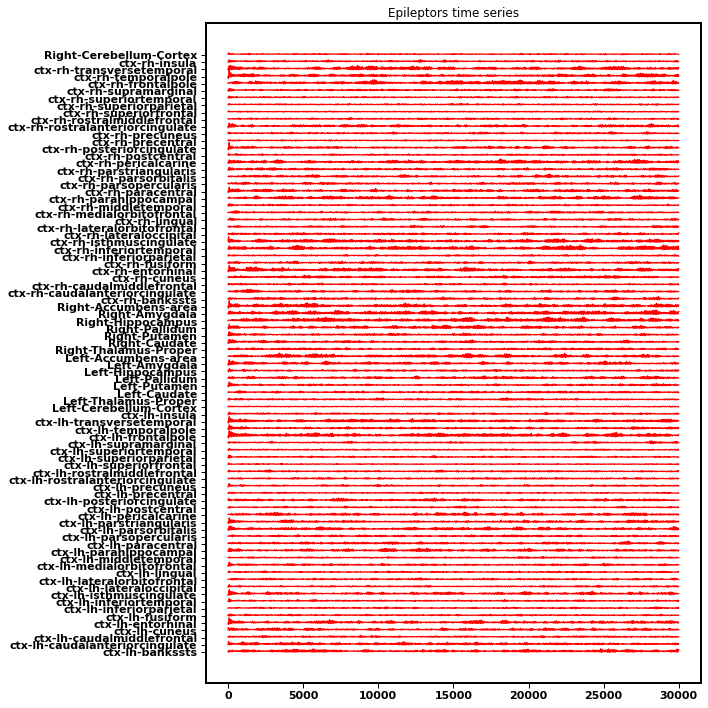

In [142]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], region_ts / (np.max(region_ts.max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

Index(['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'A1',
       'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B9', 'B10', 'B11', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6',
       'OT7', 'OT8', 'OT9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2',
       'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'OP1', 'OP2', 'OP3',
       'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9'],
      dtype='object')


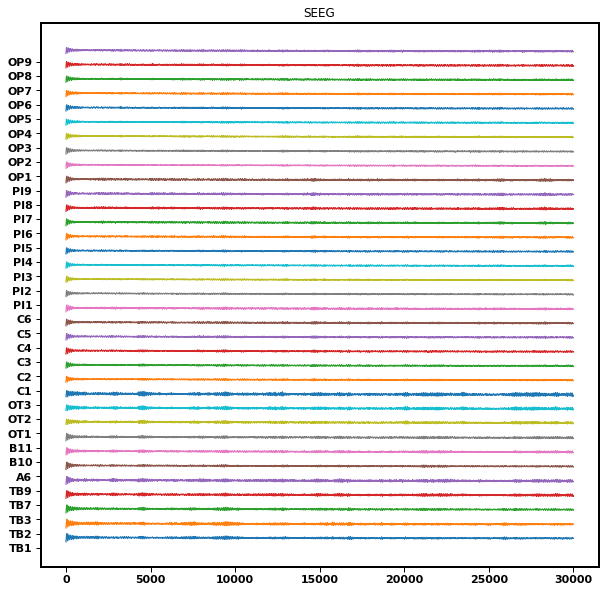

In [146]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg_ts / np.max(seeg_ts, axis=0)  + np.r_[:len(nrz_ch_names)])
plt.yticks(np.r_[:len(nrz_ch_names)], nrz_ch_names[:len(nrz_ch_names)])
plt.title("SEEG")

print(ch_names)

In [147]:
resected_ch_names = [ch for ch in ch_names if ch not in resected_chs]
print(len(resected_ch_names))

print(ieeg_mon_ts.shape, epilepts.shape)

35
(30000, 2, 35, 1) (30000, 9, 84, 1)


In [145]:
np.savez_compressed(output_path / partial_resect_bids_path.basename, 
                   epilepts=epilepts, ieeg_mon_ts=ieeg_mon_ts,
                    times=times,
                   ch_names=resected_ch_names, region_names=conn.region_labels)

## Fragility Analysis

In [42]:
# load the pre-resection data
data_dict = np.load(output_path / partial_resect_bids_path.basename, allow_pickle=True)
print(data_dict.keys())

# load in the resected data
ieeg_mon_ts = data_dict['ieeg_mon_ts']
ch_names = data_dict['ch_names']

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = p * seeg_epileptor_ts + (1-p)* seeg_rs_ts

print(seeg_ts.shape, ch_names.shape)

KeysView(<numpy.lib.npyio.NpzFile object at 0x153829160>)
(30000, 35) (35,)


In [43]:
seegdata = seeg_ts.squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=list(ch_names), 
                   ch_types='seeg')
raw = RawArray(seegdata, info=info)

# drop channels if this is a resected simulation
# resected_raw.drop_channels(resected_ch_names)

# pick types and load data to RAM
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)
raw = raw.notch_filter(freqs, method='fir')

(35, 30000)
<RawArray | 35 x 30000 (30.0 s), ~8.0 MB, data loaded>


In [44]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (35, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:02<00:00, 100.54eeg window/s]


(35,) (35, 35) (35, 35)


/Users/adam2392/Documents/eztrack/eztrack/fragility/fragility.py:745: ComplexWarning: Casting complex values to real discards the imaginary part
  A_mats[..., i] = adjmat
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

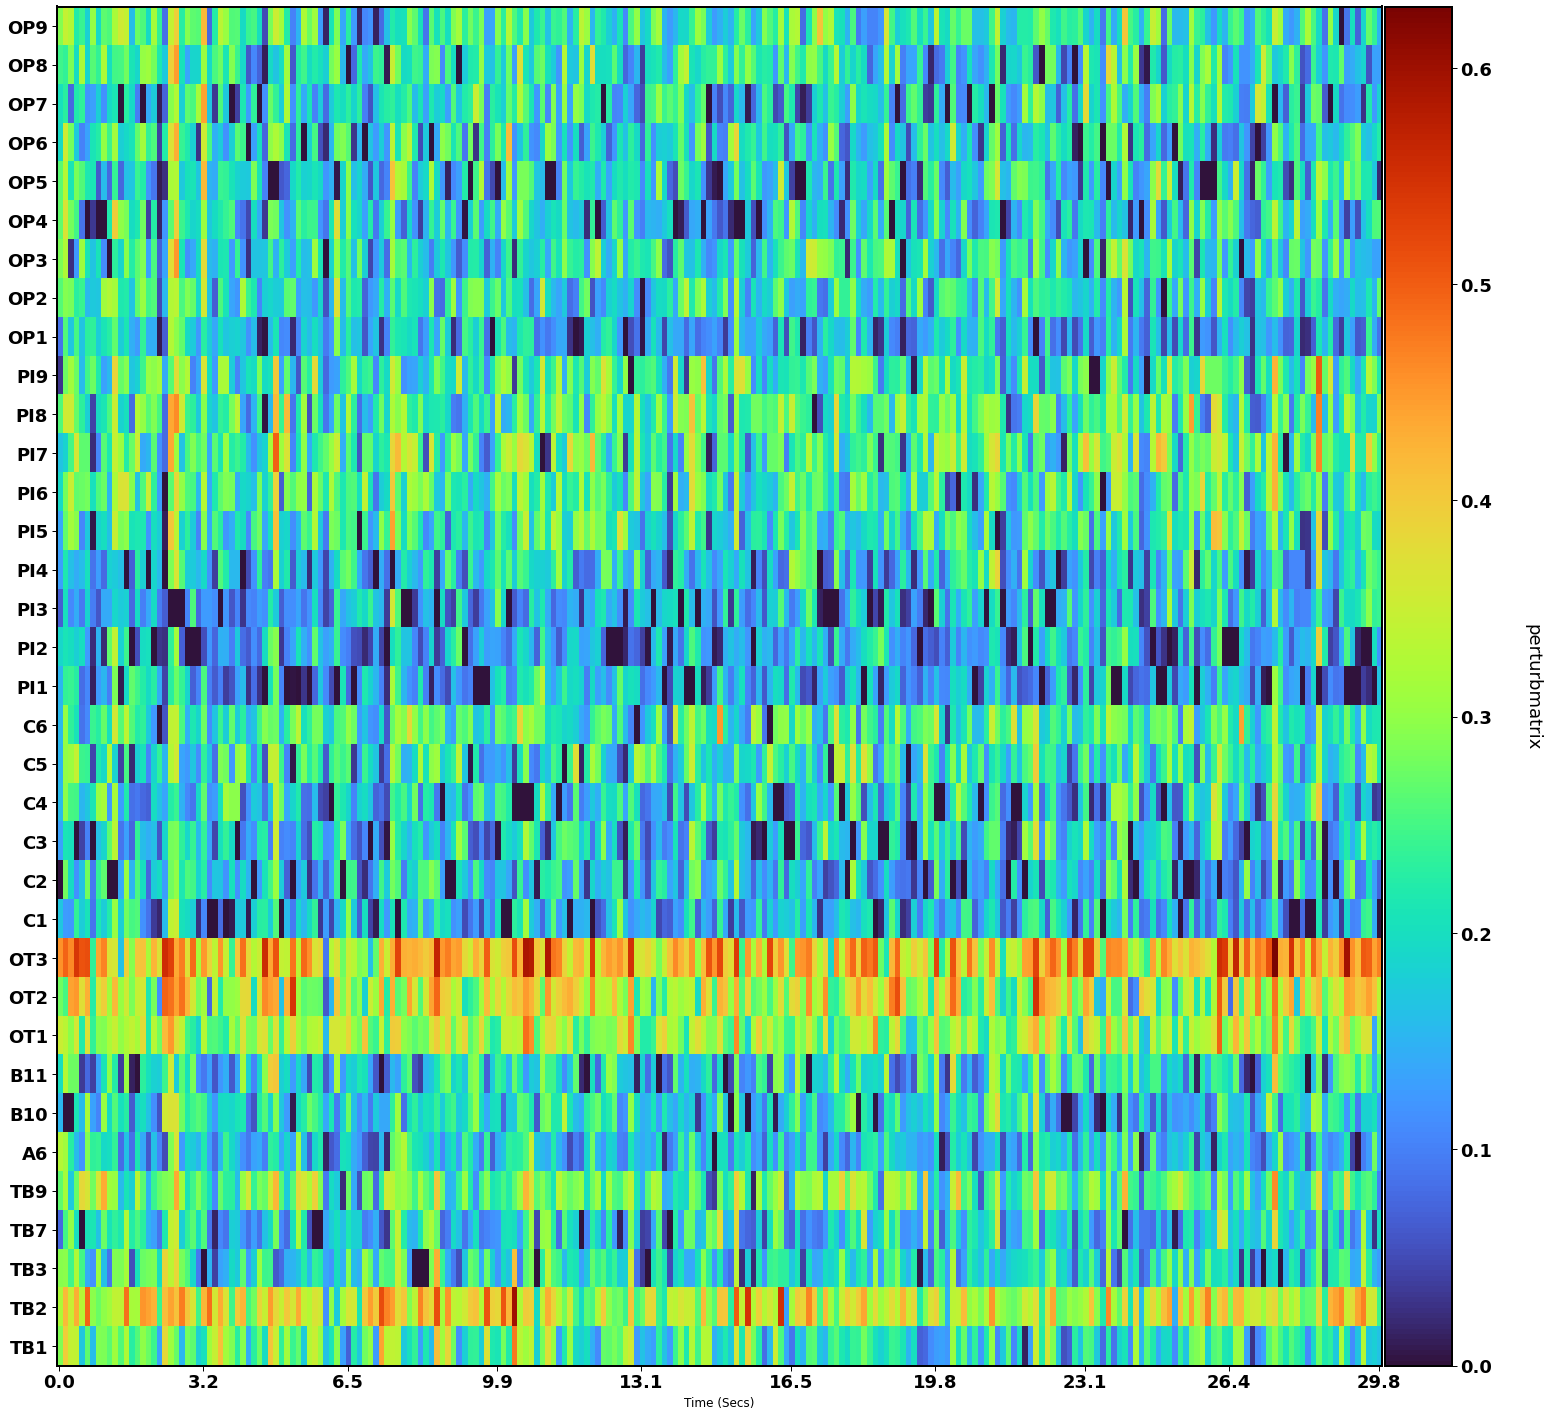

In [151]:
pert_deriv.normalize()

pert_deriv.plot_heatmap()

In [45]:
pert_deriv.save(deriv_output_path / deriv_partial_resect_path)

PosixPath('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/fragility/sub-id013pg/ses-postresection/ieeg/sub-id013pg_ses-postresection_task-tvbsimezpz_run-02_desc-perturbmatrix_ieeg.npy')

# Modeling the Fully Failed Surgical Resection

## Set Resective Region

In [157]:
if subject == 'id013pg':
    ez_label = [
#         'ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = [
#         'Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
#                 'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 
    
ez_label = ['Left-Hippocampus', 'Left-Amygdala', 'ctx-lh-fusiform', 'ctx-rh-insula']

In [158]:
# read in the ez hypothesis regions
with open(ezhypo_fpath, 'r') as fin:
    ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
print(ez_hypo)
ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(ez_regions, pz_regions)
print(ezhypo_inds)
print(ez_regions)
print(pzhypo_inds)
print(pz_regions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
['ctx-lh-fusiform' 'Left-Hippocampus' 'Left-Amygdala' 'ctx-rh-insula'] []
(array([ 5, 39, 40, 82]),)
['ctx-lh-fusiform' 'Left-Hippocampus' 'Left-Amygdala' 'ctx-rh-insula']
(array([], dtype=int64),)
[]


## Resect region on Structural Connectivity and Remove Channels

In [159]:
conn = resect_regions(conn, ezhypo_inds)
conn = resect_regions(conn, pzhypo_inds)
print(conn.summary_info())

{'Number of regions': 0, 'Number of connections': 0, 'Undirected': False, 'areas shape': '(84,)', 'areas dtype': 'float64', 'areas [min, median, max]': '[340.84, 2223.93, 16020.4]', 'weights shape': '(84, 84)', 'weights dtype': 'float64', 'weights [min, median, max]': '[0, 0.000152589, 1]', 'weights-non-zero [min, median, max]': '[3.54859e-06, 0.000269693, 1]', 'tract_lengths [min, median, max]': '[0, 116.056, 197.187]', 'tract_lengths-non-zero [min, median, max]': '[12.19, 118.817, 197.187]', 'tract_lengths (connections) [min, median, max]': '[12.19, 119.705, 197.187]'}


In [160]:
# load the location of each electrodes
electrodes_path = rawsim_bids_path.copy().update(
    root=root, task=None, run=None, suffix='electrodes', 
    session='extraoperative',
    acquisition='seeg', space='mri', extension='.tsv')
print(electrodes_path)

elec_df = pd.read_csv(electrodes_path, delimiter='\t')
display(elec_df.head())

elec_names = elec_df.name.tolist()
elec_regions = elec_df['desikan-killiany'].tolist()

print(elec_names)
# resected channels
resected_chs = [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in ez_label]
pz_resected_chs =  [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in pz_label]
resected_chs.extend(pz_resected_chs)
print('Resected these channels: ', resected_chs)

/Users/adam2392/Dropbox/resection_tvb/sub-id013pg/ses-extraoperative/ieeg/sub-id013pg_ses-extraoperative_acq-seeg_space-mri_electrodes.tsv


name      x     y      z  size desikan-killiany
0   A1    NaN   NaN    NaN   NaN   Right-Amygdala
1   A2    NaN   NaN    NaN   NaN   Right-Amygdala
2   A3  40.56  0.72 -22.77   NaN   Right-Amygdala
3   A4  44.05  0.77 -22.95   NaN   Right-Amygdala
4   A5  47.55  0.82 -23.12   NaN   Right-Amygdala

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9', 'OT10', 'OP1', 'OP2', 'OP3', 'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9', 'OP10', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'PI10', 'ECG']
Resected these channels:  ['OP1', 'OP2']


In [161]:
# ez_label = ['ctx-rh-medialorbitofrontal']
# pz_label = ['ctx-rh-lateralorbitofrontal']
# # get the hypothesized EZ and PZ
# ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
# ez_regions = conn.region_labels[ezhypo_inds]

# pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
# pz_regions = conn.region_labels[pzhypo_inds]


In [162]:
# and re-save it as a temporary file
seeg_pd = pd.read_csv(ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

# load in the gain file and remove the indices
ch_names = seeg_pd.index
seeg_pd.drop(resected_chs, inplace=True)

# resave the dataframe
# new_seeg_fname = os.path.join(temp_path, os.path.basename(seeg_fname))
# seeg_pd.to_csv('./test.txt', sep=' ', columns=None, header=False)

In [163]:
nrz_ch_names = [ch for ch in ch_names if ch not in resected_chs]

print('Channels not resected...')
print(nrz_ch_names)

Channels not resected...
['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6', 'OT7', 'OT8', 'OT9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2', 'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'OP3', 'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9']


## Setup Resected Brain Simulation

In [164]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
#     ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
    resected_chs=resected_chs,
    variables_of_interest=epileptor_vars,
    x0ez=-2.08, x0pz=-2.10, resting_state=resting_state
)

[<tvb.simulator.monitors.TemporalAverage object at 0x148689d90>, <tvb.simulator.monitors.iEEG object at 0x149587280>]
   INFO  Projection configured gain shape (57, 84)


In [165]:
sim_length = 30000
(times, epilepts), (_, ieeg_mon_ts) = sim.run(
        simulation_length=sim_length)

In [166]:
# get the actual data arrays

# get the discharges of each model
# for the epileptor: it is 'x2 - x1'
# for the 2D oscillator: it is 'x_rs'
epileptor_ts = epilepts[:, -1, :, :]
oscillator_ts = epilepts[:, 6, :, :]
region_ts = (epileptor_ts - oscillator_ts).squeeze()

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = seeg_epileptor_ts +seeg_rs_ts

print(seeg_epileptor_ts.shape, seeg_rs_ts.shape)
print(seeg_ts.shape, region_ts.shape)

(30000, 57) (30000, 57)
(30000, 57) (30000, 84)


## Visualize and save output of the simulation

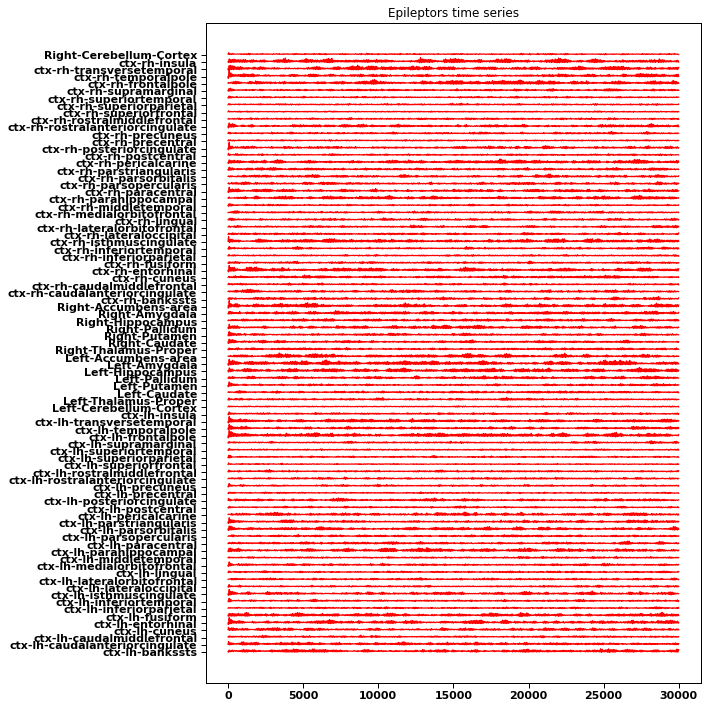

In [167]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], region_ts / (np.max(region_ts.max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

Index(['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'A1',
       'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B9', 'B10', 'B11', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'OT6',
       'OT7', 'OT8', 'OT9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'PI1', 'PI2',
       'PI3', 'PI4', 'PI5', 'PI6', 'PI7', 'PI8', 'PI9', 'OP1', 'OP2', 'OP3',
       'OP4', 'OP5', 'OP6', 'OP7', 'OP8', 'OP9'],
      dtype='object')


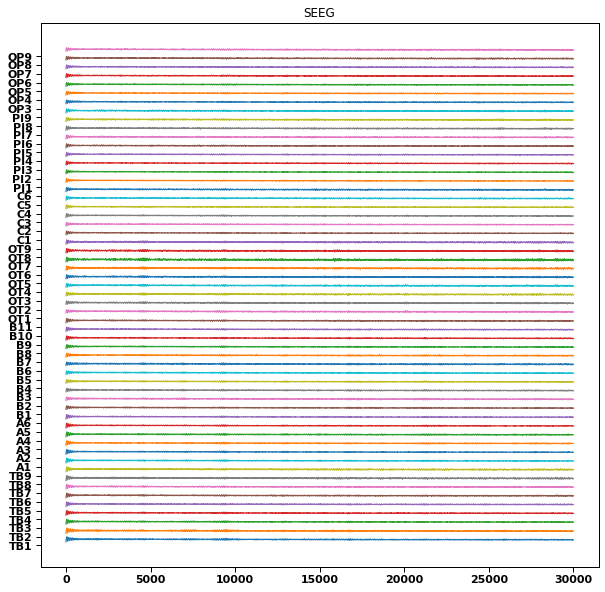

In [168]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg_ts / np.max(seeg_ts, axis=0)  + np.r_[:len(nrz_ch_names)])
plt.yticks(np.r_[:len(nrz_ch_names)], nrz_ch_names[:len(nrz_ch_names)])
plt.title("SEEG")

print(ch_names)

In [169]:
resected_ch_names = [ch for ch in ch_names if ch not in resected_chs]
print(len(resected_ch_names))

print(ieeg_mon_ts.shape, epilepts.shape)

57
(30000, 2, 57, 1) (30000, 9, 84, 1)


In [170]:
np.savez_compressed(output_path / fail_resect_bids_path.basename, 
                   epilepts=epilepts, ieeg_mon_ts=ieeg_mon_ts,
                    times=times,
                   ch_names=resected_ch_names, region_names=conn.region_labels)

## Fragility Analysis

In [46]:
# load the pre-resection data
data_dict = np.load(output_path / fail_resect_bids_path.basename, allow_pickle=True)
print(data_dict.keys())

# load in the resected data
ieeg_mon_ts = data_dict['ieeg_mon_ts']
ch_names = data_dict['ch_names']

# combine the sEEG by adding
seeg_epileptor_ts = ieeg_mon_ts[:, 1, :, :].squeeze()
seeg_rs_ts = ieeg_mon_ts[:, 0, :, :].squeeze()
seeg_ts = p * seeg_epileptor_ts + (1-p)* seeg_rs_ts

print(seeg_ts.shape, ch_names.shape)

KeysView(<numpy.lib.npyio.NpzFile object at 0x15381a610>)
(30000, 57) (57,)


In [47]:
seegdata = seeg_ts.squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=list(ch_names), 
                   ch_types='seeg')
raw = RawArray(seegdata, info=info)

# drop channels if this is a resected simulation
# resected_raw.drop_channels(resected_ch_names)

# pick types and load data to RAM
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)
raw = raw.notch_filter(freqs, method='fir')

(57, 30000)
<RawArray | 57 x 30000 (30.0 s), ~13.1 MB, data loaded>


In [50]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (57, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:07<00:00, 32.63eeg window/s]


(57,) (57, 57) (57, 57)


/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

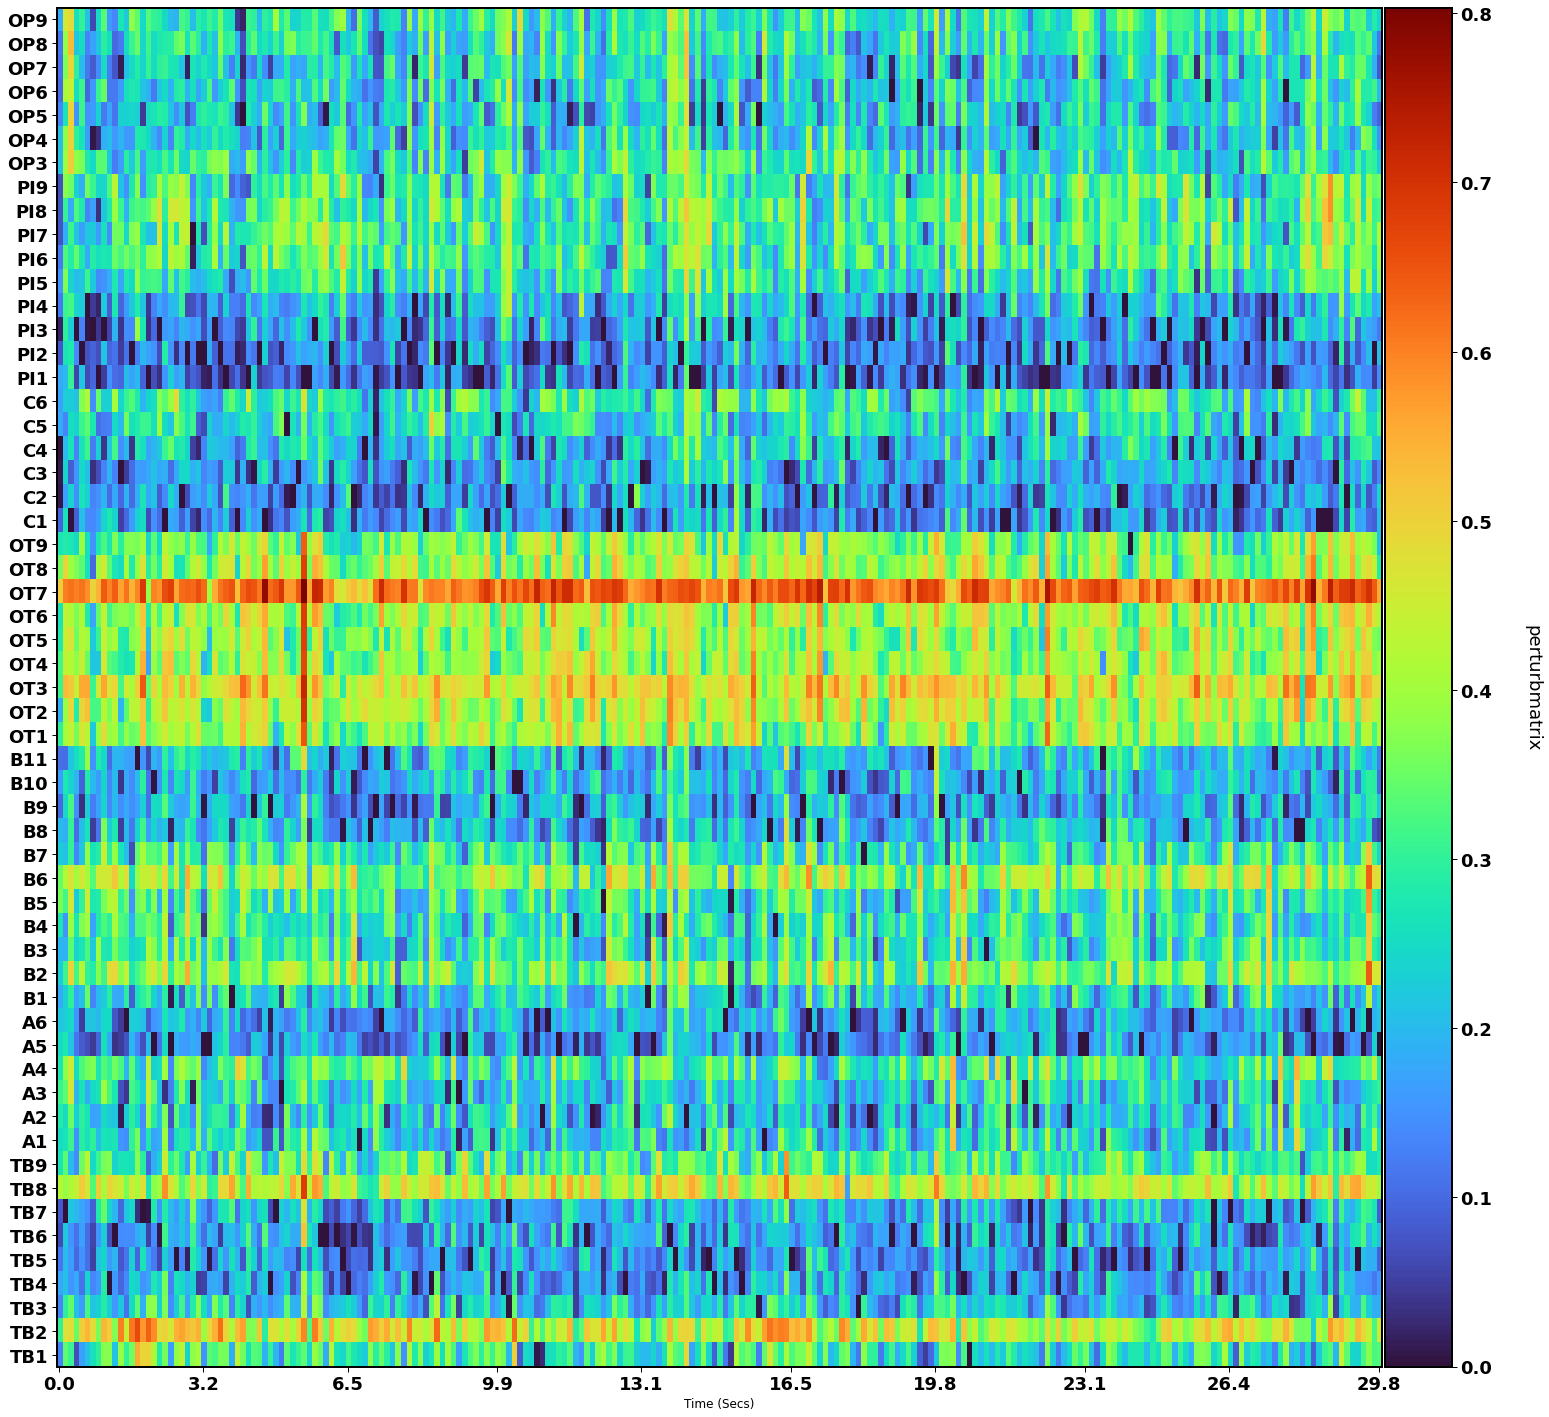

In [49]:
pert_deriv.normalize()

pert_deriv.plot_heatmap()

In [51]:
pert_deriv.save(deriv_output_path / deriv_fail_resect_path)

PosixPath('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/fragility/sub-id013pg/ses-postresection/ieeg/sub-id013pg_ses-postresection_task-tvbsimezpz_run-03_desc-perturbmatrix_ieeg.npy')

# Comparing Resection Using Fragility

Now, load in the preresection heatmap and all the post resection heatmaps. We can perform a statistical and quantitative comparison across the proposed resections.

In [18]:
pre_deriv = read_derivative_npy(deriv_output_path / deriv_base_path)
succ_deriv = read_derivative_npy(deriv_output_path / deriv_succ_resect_path)
partial_deriv = read_derivative_npy(deriv_output_path / deriv_partial_resect_path)
fail_deriv = read_derivative_npy(deriv_output_path / deriv_fail_resect_path)

# crop pre_deriv to get rid of the start of seizure period
pre_deriv.load_data()
succ_deriv.load_data()
partial_deriv.load_data()
fail_deriv.load_data()

pre_deriv.normalize()
succ_deriv.normalize()
partial_deriv.normalize()
fail_deriv.normalize()
print(len(pre_deriv))
pre_deriv = pre_deriv.crop(tmin=0, tmax=25)
print(len(pre_deriv))
print(pre_deriv._first_samps, pre_deriv._last_samps)

239
201
[0] [200]


In [19]:
def add_derivatives(deriv1, deriv2):
    deriv1 = deriv1.copy()
    deriv2 = deriv2.copy()
    
    deriv1.load_data()
    deriv2.load_data()
    

    deriv1.normalize()
    deriv2.normalize()
    
    if not all([ch in deriv1.ch_names for ch in deriv2.ch_names]):
        # get the set difference of channels
        add_chs = list(set(deriv2.ch_names) - set(deriv1.ch_names))
        ch_type = deriv2.get_channel_types()[0]
        info = create_deriv_info(ch_names=add_chs, sfreq=deriv2.info['sfreq'], 
                                 ch_types=ch_type, 
                                 description=deriv2.description,
                                ch_axis=[0])
        addderiv = DerivativeArray(np.ones((len(add_chs), len(deriv1)))*-1, info=info, verbose=False)

        # add derivative chs
        deriv1 = deriv1.add_channels([addderiv])

        deriv2.reorder_channels(deriv2.ch_names)

    derivs = [deriv2, deriv1]
    new_deriv = concatenate_derivs(derivs)
    return new_deriv


presucc_deriv = add_derivatives(succ_deriv, pre_deriv)
prepart_deriv = add_derivatives(partial_deriv, pre_deriv)
prefail_deriv = add_derivatives(fail_deriv, pre_deriv)

/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)
/Users/adam2392/Documents/eztrack/eztrack/utils/_logging.py:133: RuntimeWarning: Already normalized Derivative!
  mne_warn(message, category, module)


/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:306: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_under("gray")
/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1783.22x1782.1 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

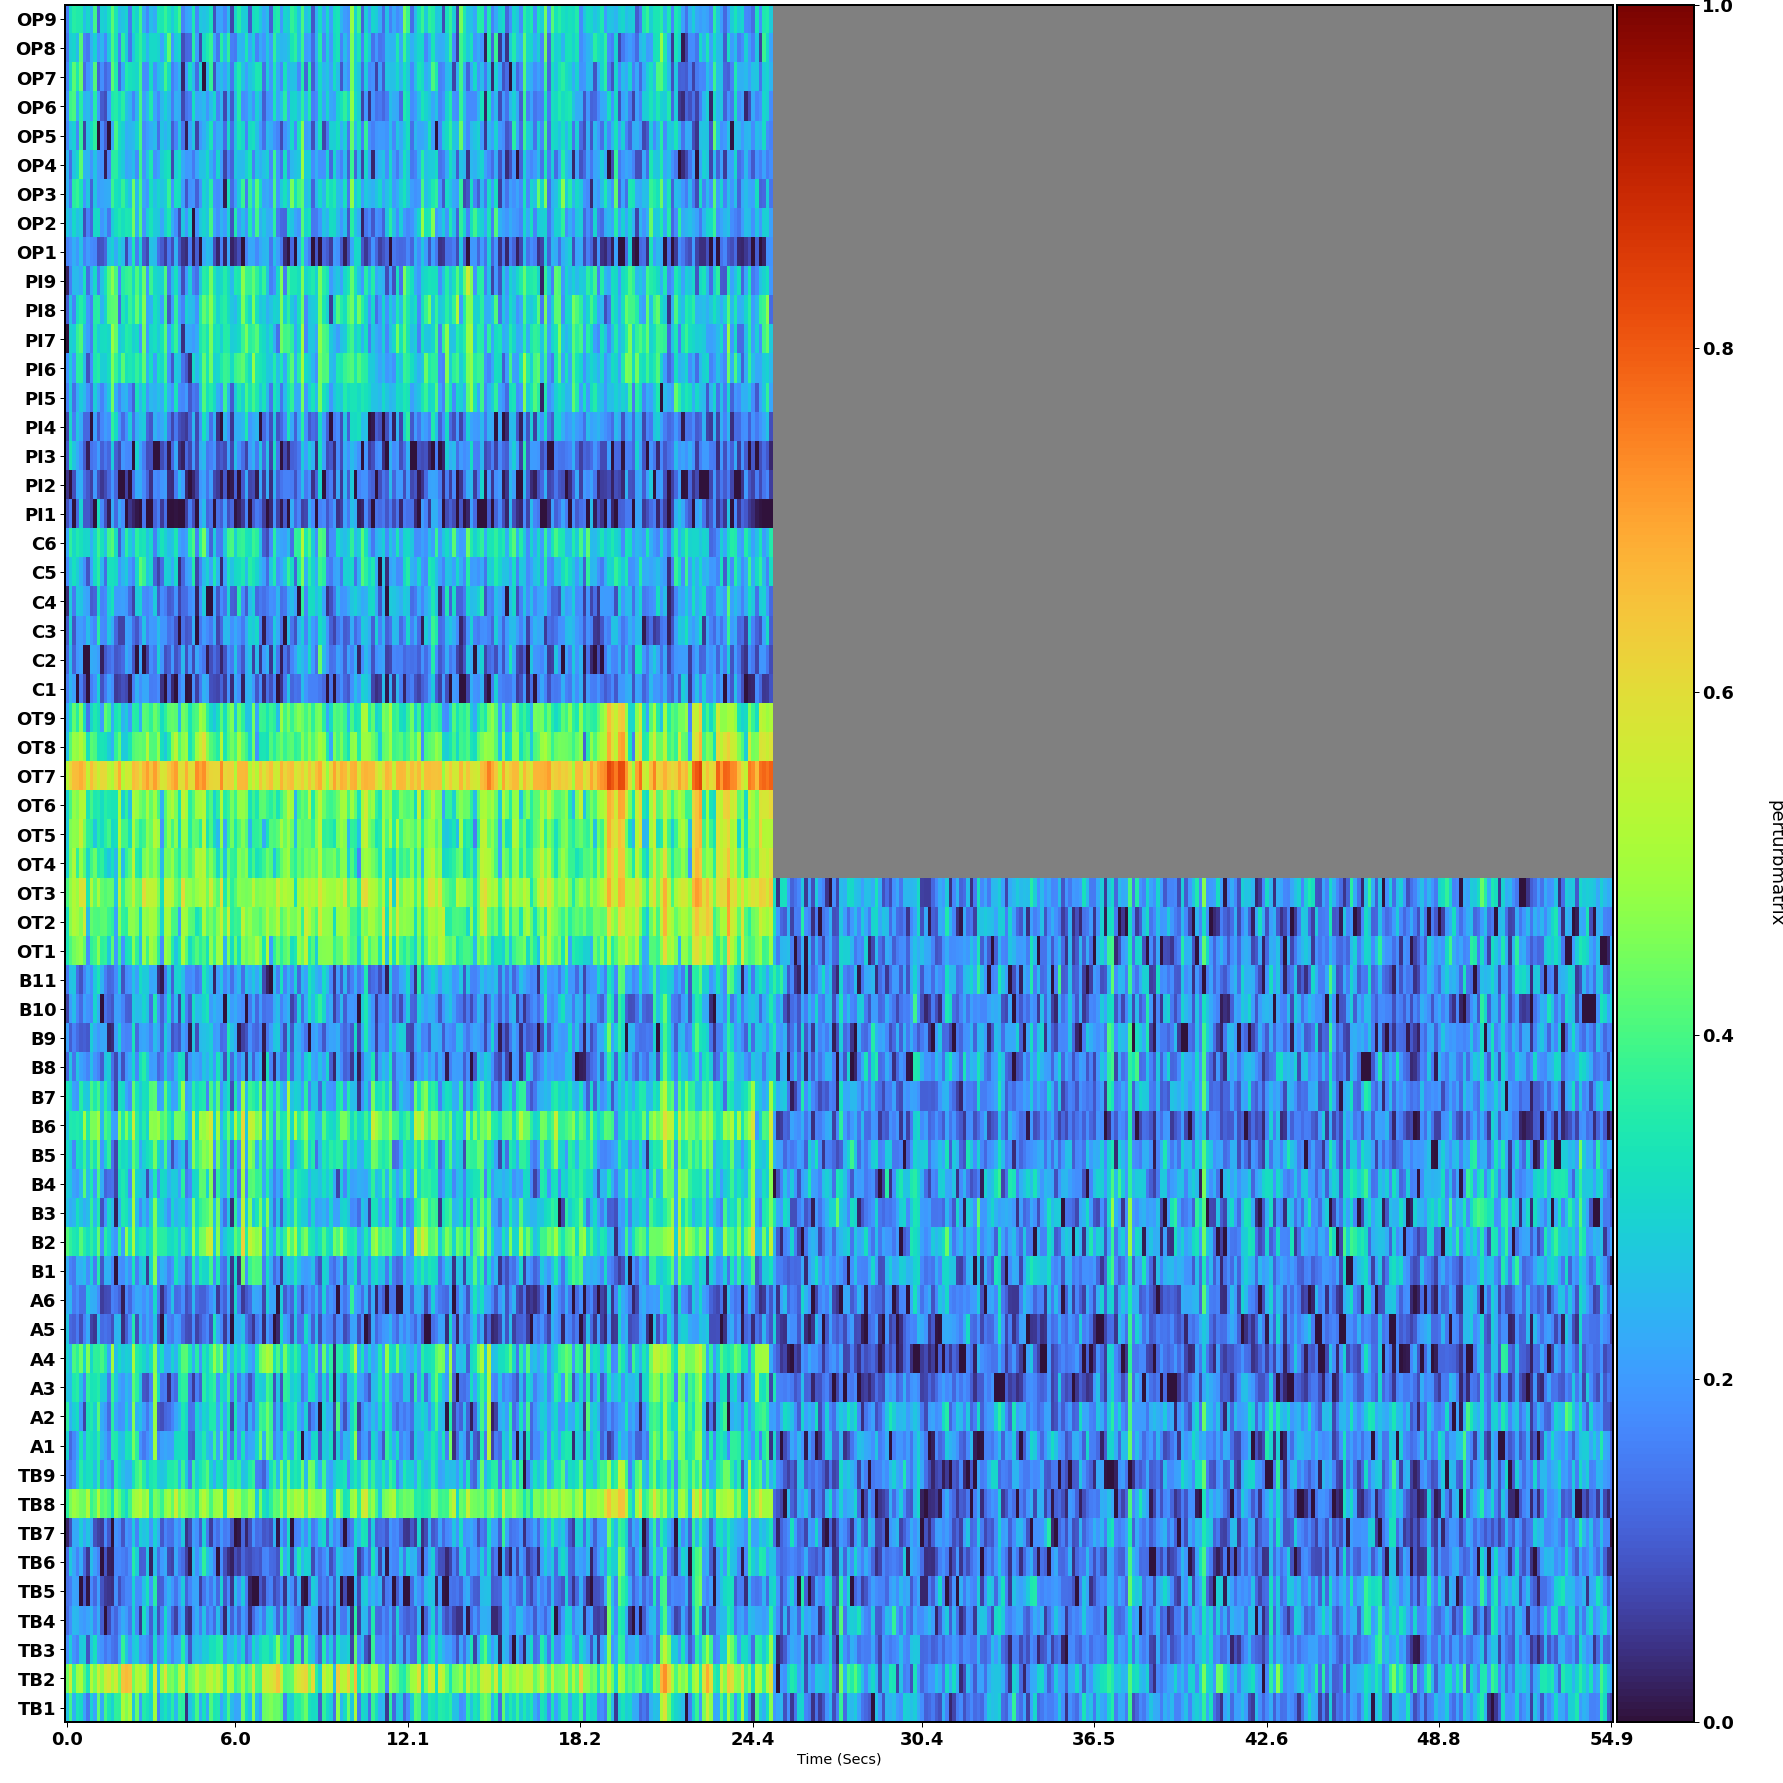

In [58]:
presucc_deriv.plot_heatmap(vmin=0, vmax=1,
                               set_col_under=True,
                          figure_fpath=figures_path / f'{subject}-successfulresection-fragilityheatmap.pdf')

/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:306: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_under("gray")
/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1783.22x1782.1 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

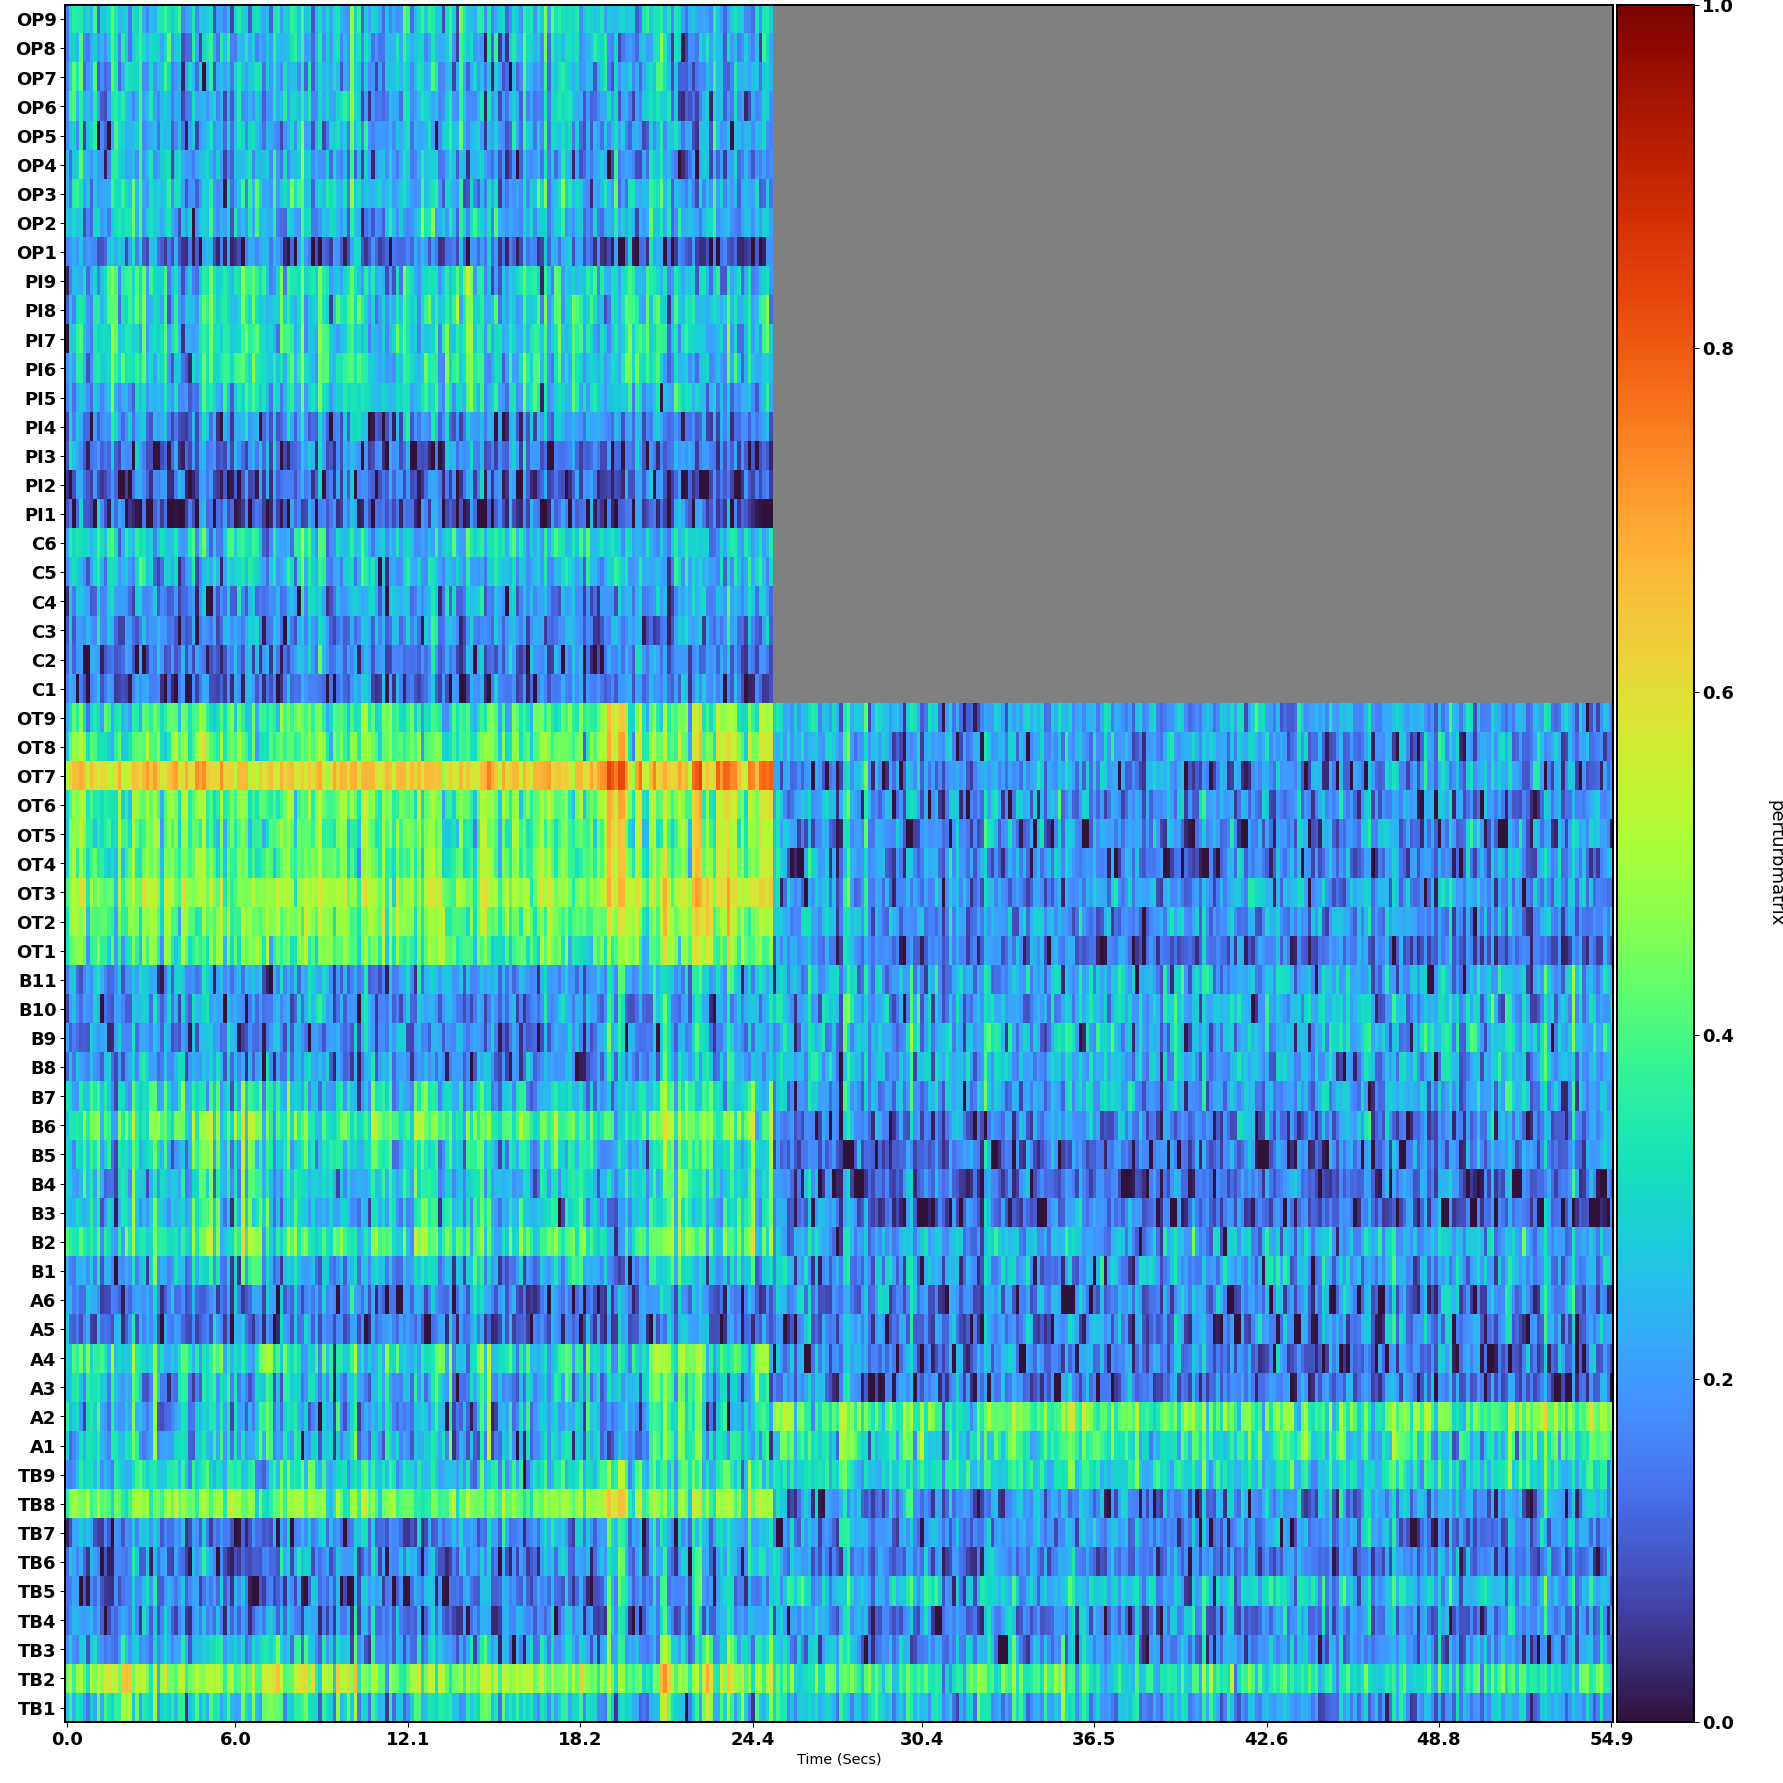

In [59]:
prepart_deriv.plot_heatmap(vmin=0, vmax=1,
                                                          set_col_under=True,
                          figure_fpath=figures_path / f'{subject}-partialfailresection-fragilityheatmap.pdf')

/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:306: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_under("gray")
/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1783.22x1782.1 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

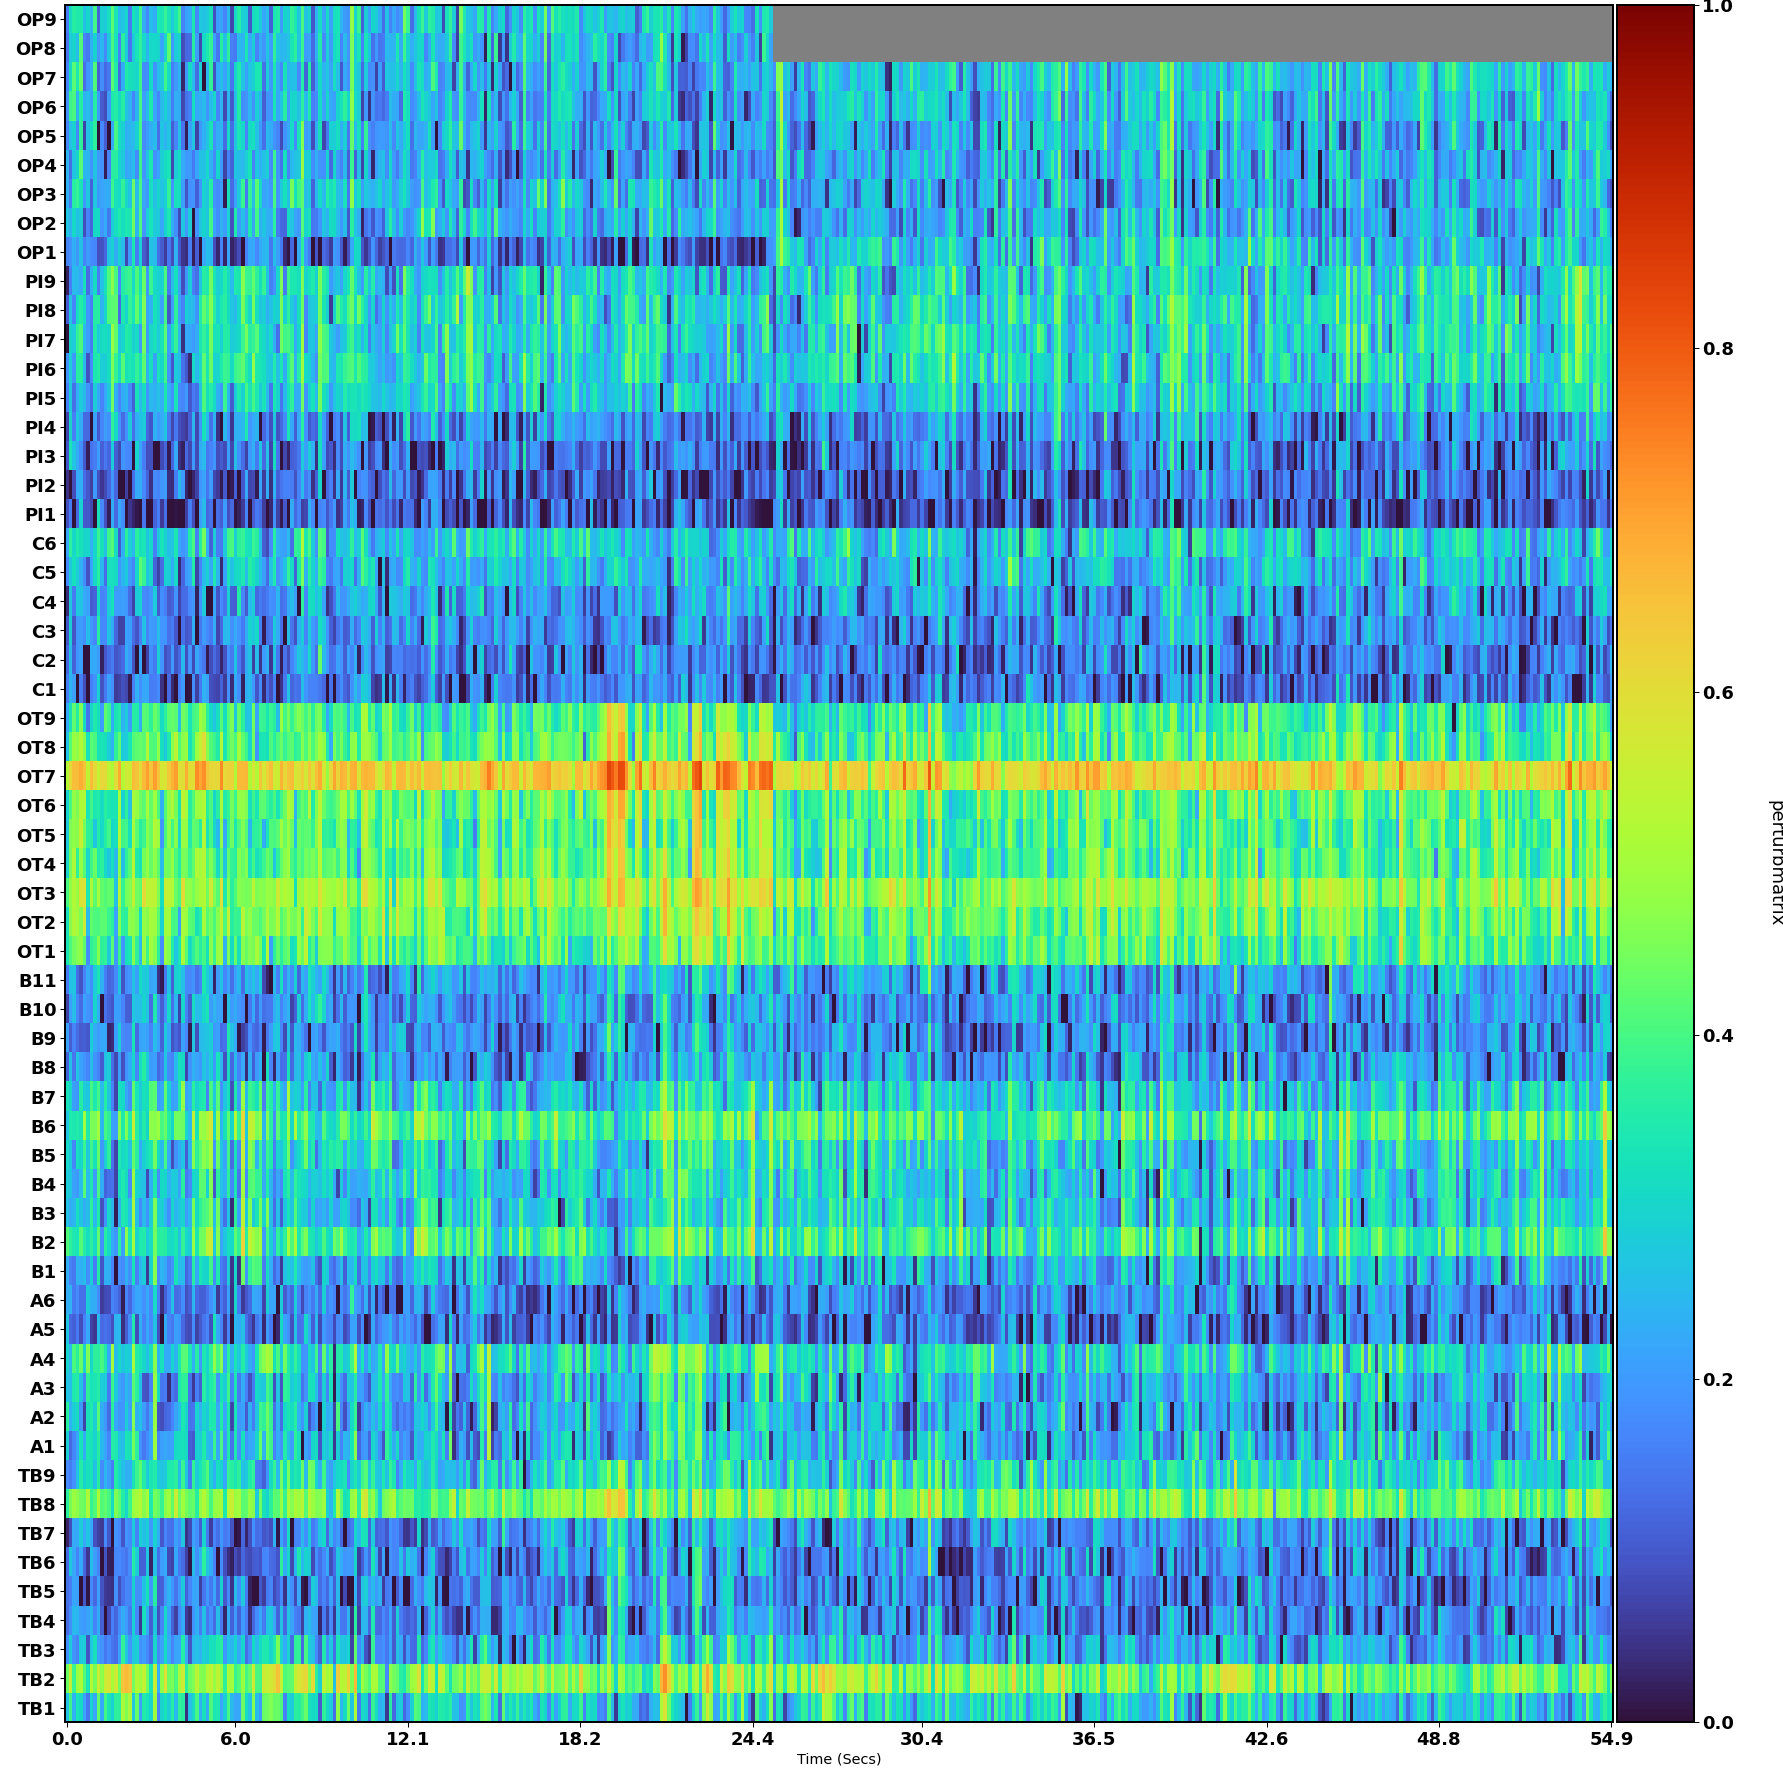

In [60]:
prefail_deriv.plot_heatmap(vmin=0, vmax=1, set_col_under=True,
                          figure_fpath=figures_path / f'{subject}-failresection-fragilityheatmap.pdf')

## Bootstrap block comparison

In [20]:
df = pd.DataFrame()
threshold = None

In [21]:
for desc, post_deriv in zip(['successful', 'partial-fail', 'fail'], [succ_deriv, partial_deriv, fail_deriv]):
    df_summ = []
    
    # compute block-bootstrap statistics
    cohensd, stats, pvals = compute_block_bootstrap_stats(pre_deriv, post_deriv, desc=desc,
                                                          df_summ=df_summ, threshold=threshold)

    # create 
    this_df = pd.DataFrame(df_summ, columns=['desc', 'es', 'stat', 'pval'])
    if df.empty:
        df = this_df
    else:
        df = pd.concat((df, this_df), axis=0)

In [24]:
display(df.head())

desc        es      stat          pval
0  successful  0.490586  0.053603  3.906212e-12
1  successful  0.886695  0.156600  4.852126e-32
2  successful  1.000896  0.190560  1.427958e-38
3  successful  0.597654  0.075362  2.310292e-16
4  successful  0.776757  0.115047  4.914568e-24

In [22]:
df_copy = df.copy()

In [31]:
df = df_copy.copy()[df_copy['desc'] == 'fail']

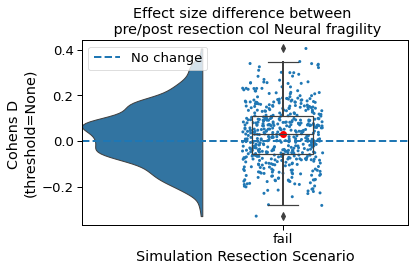

In [32]:
ort="v"; pal = "Set2"; sigma = .2
pal = sns.color_palette(n_colors=1)
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots()
pt.RainCloud(x='desc', y='es', data = df, 
             palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, 
            pointplot=True)
# plot horizontal line
ax.axhline([0], ls='--', lw=2, label='No change')
ax.legend()
ax.set(
    xlabel='Simulation Resection Scenario',
    ylabel=f'Cohens D \n(threshold={threshold})',
    title=f'Effect size difference between \n pre/post resection {derivtype} Neural fragility'
)
fig.tight_layout()

# Graph Embedding Analysis of Structural Connectome

In [181]:
import graspologic
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

from hyppo.ksample import KSample

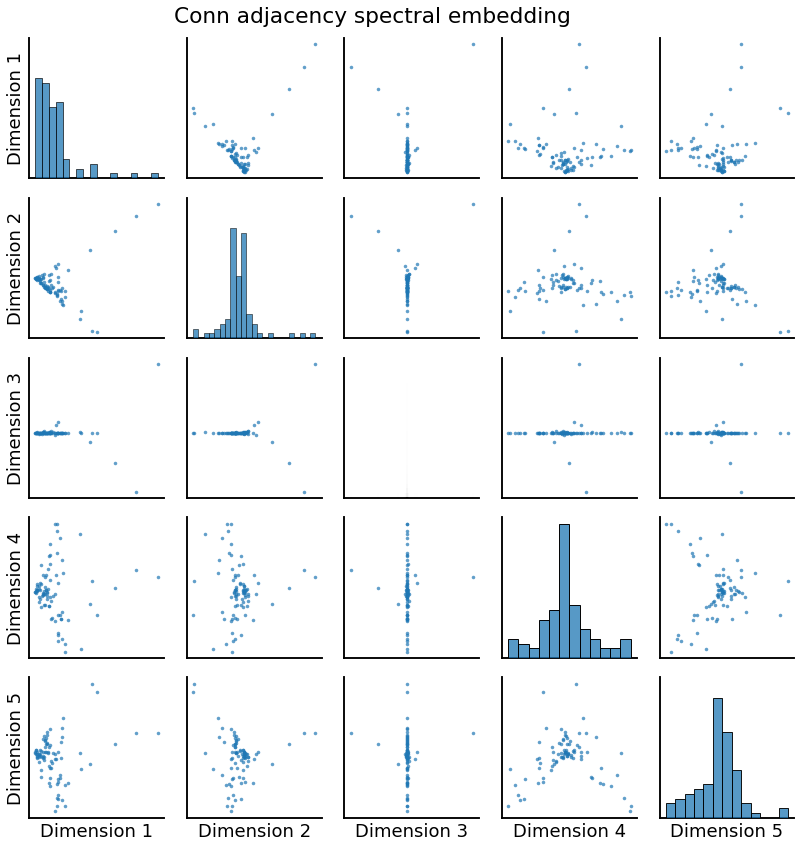

In [180]:
# instantiate an ASE object
ase = AdjacencySpectralEmbed()

# call its fit_transform method to generate latent positions
Xhat = ase.fit_transform(conn.weights)
_ = pairplot(Xhat, title='Conn adjacency spectral embedding')

(array([54]),)


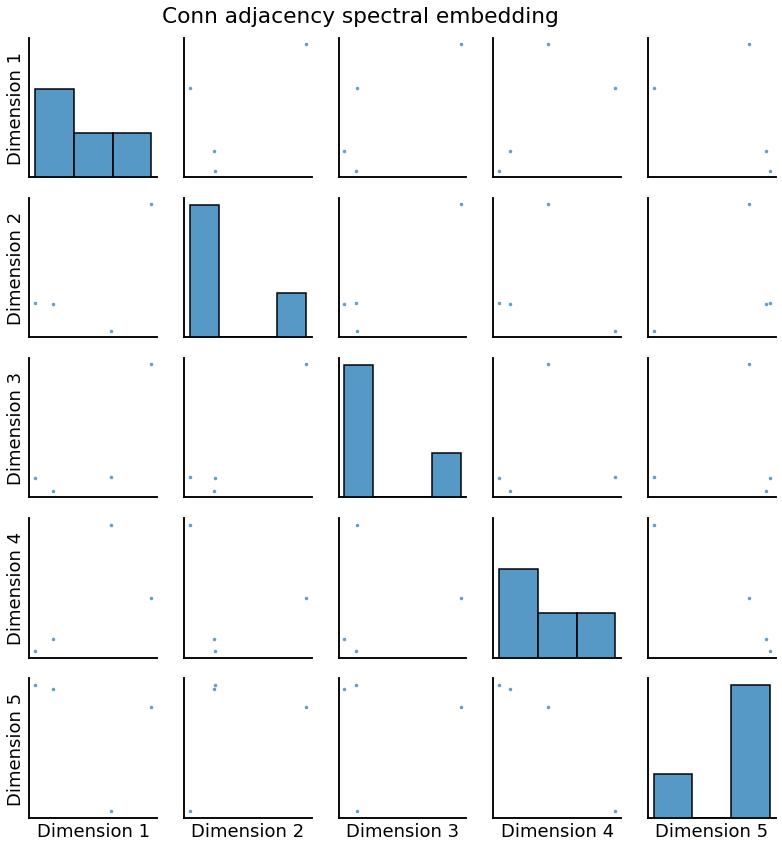

In [196]:
print(ezhypo_inds)
_ = pairplot(Xhat[np.hstack((ezhypo_inds[0], pzhypo_inds[0])),:], title='Conn adjacency spectral embedding')

<AxesSubplot:>

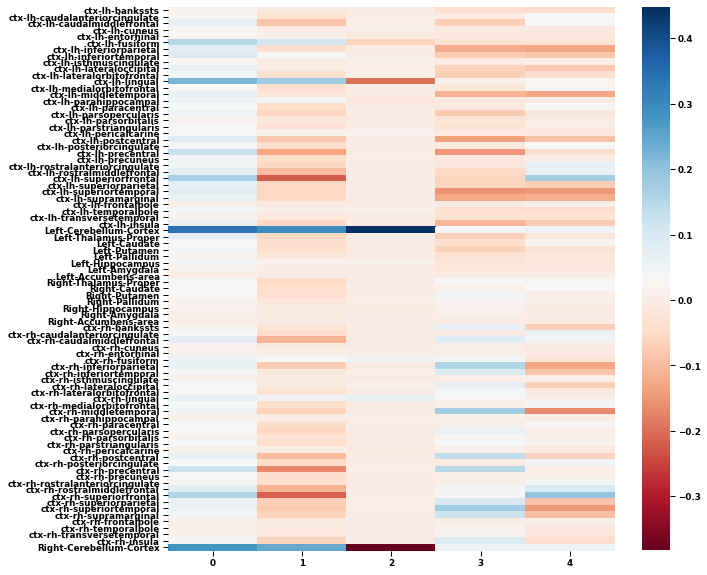

In [187]:
sns.set_context('paper')
plt.figure(figsize=(10,10))
sns.heatmap(Xhat, cmap='RdBu', yticklabels=conn.region_labels)